### Data Preprocessing

In [215]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
import matplotlib.lines as mlines

# Set Style and Format
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")


In [49]:
# Reload the two cleaned files (CNRDS and CSMAR)
file1 = "CSMAR.xlsx"
file2 = "CNRDS.xlsx"

df1 = pd.read_excel(file1, sheet_name='模板')
df2 = pd.read_excel(file2, sheet_name='上市公司ESG评级')

# Clean CNRDS
df1_clean = df1.iloc[2:].copy()
df1_clean.columns = df1.iloc[0]
df1_clean = df1_clean.dropna(subset=["股票代码"])
df1_clean = df1_clean.rename(columns={
    "股票代码": "Code",
    "股票简称": "Name",
    "评级年份": "Year",
    "评级日期":"Date",
    "公司全称": "FullName",
    "所属指数名称": "IndexName",
    "成分股标识": "ConstituentFlag",
    "证监会行业": "CSMAR_Industry",
    "融绿一级行业": "CSMAR_Industry_1",
    "融绿二级行业": "CSMAR_Industry_2",
    "ESG总评分": "ESG_CSMAR",
    "E评分": "E_CSMAR",
    "S评分": "S_CSMAR",
    "G评分": "G_CSMAR",
    "特殊说明": "SpecialNotes",
    "ESG风险评估评分":"ESGRiskScore",
    "ESG管理评分":"ESGManagementscore"
})

# Clean CSMAR
df2_clean = df2.iloc[1:].copy()
df2_clean.columns = df2.iloc[0]
df2_clean = df2_clean.dropna(subset=["股票代码"])
df2_clean = df2_clean.rename(columns={
    "股票代码": "Code",
    "公司简称": "Name",
    "会计年度": "Year",
    "ESG得分": "ESG_CNRDS",
    "E得分": "E_CNRDS",
    "S得分": "S_CNRDS",
    "G得分": "G_CNRDS",
    "ESG排名": "ESG_CNRDS_rank",
    "E排名": "E_CNRDS_rank",
    "S排名": "S_CNRDS_rank",
    "G排名": "G_CNRDS_rank",
})

# Type Conversion
for df in [df1_clean, df2_clean]:
    df["Year"] = df["Year"].astype(int)
    for col in ["ESG_CNRDS", "E_CNRDS", "S_CNRDS", "G_CNRDS",
                "ESG_CSMAR", "E_CSMAR", "S_CSMAR", "G_CSMAR"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Merge (Outer Join)
merged_full = pd.merge(df1_clean, df2_clean, on=["Code", "Year","Name"], how="outer")

# Retain samples where data exists in both systems
merged_matched = merged_full.dropna(subset=["ESG_CNRDS", "ESG_CSMAR"])

# Output sample size statistics
num_rows = len(merged_matched)
num_companies = merged_matched["Code"].nunique()

# merged_matched.head(), num_rows, num_companies


In [50]:
# Read the file (using the merged file you generated earlier).
df = merged_matched

# Industry Mapping Dictionary (Chinese to English, academic style)
industry_map = {
    # Original Base Mapping
    "资本市场服务": "Capital Market Services",
    "银行业": "Banking",
    "保险业": "Insurance",
    "证券业": "Securities",
    "金属制品业": "Manufacture of Metal Products",
    "运输设备制造业": "Manufacture of Transport Equipment",
    "铁路、船舶、航空航天和其他运输设备制造业": "Manufacture of Railway, Ship, Aerospace and Other Transport Equipment",
    "原材料加工制造业": "Raw Materials Manufacturing",
    "化学原料及化学制品制造业": "Manufacture of Chemicals and Chemical Products",
    "金融业": "Finance Industry",
    "非银金融业": "Non-bank Financial Industry",
    "制造业": "Manufacturing",
    "批发和零售业": "Wholesale and Retail Trade",
    "房地产业": "Real Estate",
    "电力、热力、燃气及水生产和供应业": "Electricity, Heat, Gas and Water Supply",
    "采矿业": "Mining Industry",
    "农、林、牧、渔业": "Agriculture, Forestry, Animal Husbandry and Fishery",
    "软件和信息技术服务业": "Software and Information Technology Services",
    "信息传输、软件和信息技术服务业": "Information Transmission, Software and IT Services",
    "交通运输、仓储和邮政业": "Transportation, Storage and Postal Services",
    "文化、体育和娱乐业": "Culture, Sports and Entertainment",
    "教育": "Education",
    "卫生和社会工作": "Health and Social Work",
    "科学研究和技术服务业": "Scientific Research and Technical Services",
    "租赁和商务服务业": "Leasing and Business Services",
    "公共管理、社会保障和社会组织": "Public Administration, Social Security and Organizations",
    "货币金融服务": "Monetary Financial Services",
    "综合": "Comprehensive",
    "电力、热力生产和供应业": "Production and Supply of Electricity and Heat",
    "有色金属冶炼和压延加工业": "Smelting and Rolling of Nonferrous Metals",
    "黑色金属冶炼和压延加工业": "Smelting and Rolling of Ferrous Metals",
    "金属冶炼和压延加工业": "Smelting and Rolling of Metals",
    "商务服务业": "Business Services",
    "广播、电视、电影和影视录音制作业": "Radio, Television, Film and Audio-Video Production",
    "租赁业": "Leasing",
    "水的生产和供应业": "Water Production and Supply",
    "石油加工、炼焦及核燃料加工业": "Processing of Petroleum, Coking and Nuclear Fuel",
    "非金属矿物制品业": "Manufacture of Non-metallic Mineral Products",
    "农副食品加工业": "Processing of Agricultural and Sideline Food",
    "电信、广播电视和卫星传输服务": "Telecommunications, Broadcasting and Satellite Transmission Services",
    "煤炭开采和洗选业": "Coal Mining and Washing",
    "土木工程建筑业": "Civil Engineering Construction",
    "零售业": "Retail Trade",
    "批发业": "Wholesale Trade",
    "道路运输业": "Road Transport",
    "铁路运输业": "Rail Transport",
    "航空运输业": "Air Transport",
    "水上运输业": "Water Transport",
    "邮政业": "Postal Services",
    "互联网和相关服务": "Internet and Related Services",
    "畜牧业": "Animal Husbandry",
    "造纸及纸制品业": "Manufacture of Paper and Paper Products",
    "生态保护和环境治理业": "Ecological Protection and Environmental Governance",
    "文化艺术业": "Culture and Arts",
    "石油和天然气开采业": "Extraction of Petroleum and Natural Gas",
    "建筑业": "Construction",
    "建筑业-土木工程建筑业": "Construction - Civil Engineering",
    "建筑装饰和其他建筑业": "Building Decoration and Other Construction",
    "开采辅助活动": "Support Activities for Mining",
    "新闻和出版业": "News and Publishing",
    "纺织服装、服饰业": "Textile, Apparel and Accessories",
    "纺织业": "Textile Industry",
    "有色金属矿采选业": "Nonferrous Metal Mining and Dressing",
    "黑色金属矿采选业": "Ferrous Metal Mining and Dressing",
    "燃气生产和供应业": "Gas Production and Supply",
    "食品与主要用品零售": "Food and Essential Goods Retail",
    "橡胶和塑料制品业": "Manufacture of Rubber and Plastic Products",
    "研究和试验发展": "Research and Experimental Development",
    "卫生": "Health",
    "农业": "Agriculture",
    "其他运输业和邮政业": "Other Transport and Postal Services",
    "水利、环境和公共设施管理业": "Water Conservancy, Environment and Public Facilities Management",
    "其他服务业": "Other Services",
    "（已退市）": "Delisted"
}

# Define a translation function
def translate_industry(value):
    if pd.isna(value):
        return None
    for k, v in industry_map.items():
        if k in str(value):
            return v
    return value  # 如果没找到匹配，就保留原文

# Add English column
df["CSMAR_Industry"] = df["CSMAR_Industry"].apply(translate_industry)
df["CSMAR_Industry_1"] = df["CSMAR_Industry_1"].apply(translate_industry)
df["CSMAR_Industry_2"] = df["CSMAR_Industry_2"].apply(translate_industry)
df = df.drop(columns=["评级", "ConstituentFlag", "IndexName"])

# Export new file
# output_path = "ESG_with_Industry_English.xlsx"
# df.to_excel(output_path, index=False)

display(df.head(10))


C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2973555646.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CSMAR_Industry"] = df["CSMAR_Industry"].apply(translate_industry)
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2973555646.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CSMAR_Industry_1"] = df["CSMAR_Industry_1"].apply(translate_industry)
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2973555646.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

0   Year        Date    Code  Name    FullName               CSMAR_Industry  \
8   2015  2015-06-30  000001  平安银行  平安银行股份有限公司  Monetary Financial Services   
9   2016  2016-06-30  000001  平安银行  平安银行股份有限公司  Monetary Financial Services   
10  2017  2017-06-30  000001  平安银行  平安银行股份有限公司  Monetary Financial Services   
11  2018  2018-06-30  000001  平安银行  平安银行股份有限公司  Monetary Financial Services   
12  2019  2019-06-30  000001  平安银行  平安银行股份有限公司  Monetary Financial Services   
13  2020  2020-06-30  000001  平安银行  平安银行股份有限公司             Finance Industry   
24  2015  2015-06-30  000002   万科A  万科企业股份有限公司                  Real Estate   
25  2016  2016-06-30  000002   万科A  万科企业股份有限公司                  Real Estate   
26  2017  2017-06-30  000002   万科A  万科企业股份有限公司                  Real Estate   
27  2018  2018-06-30  000002   万科A  万科企业股份有限公司                  Real Estate   

0   CSMAR_Industry_1 CSMAR_Industry_2  ESG_CSMAR  E_CSMAR  ...  ESGRiskScore  \
8   Finance Industry          Banking     49.875   16.875  ...          31.5   
9   Finance Industry          Banking     49.625   17.125  ...          31.5   
10  Finance Industry          Banking     50.500   17.625  ...          31.5   
11  Finance Industry          Banking     53.500   17.375  ...        32.375   
12  Finance Industry          Banking     55.625   17.500  ...        31.375   
13  Finance Industry          Banking     57.250   59.920  ...         80.94   
24       Real Estate      Real Estate     42.750   21.875  ...            25   
25       Real Estate      Real Estate     39.500   18.750  ...         22.25   
26       Real Estate      Real Estate     37.375   18.125  ...         22.25   
27       Real Estate      Real Estate     45.625   20.750  ...        23.875   

0   SpecialNotes ESG_CNRDS ESG_CNRDS_rank  E_CNRDS  E_CNRDS_rank  S_CNRDS  \
8            NaN   22.5939           1377   9.1170           904  25.3429   
9            NaN   30.5909            735  10.7647           914  35.9205   
10           NaN   27.7715           1195  10.7223          1011  37.4645   
11           NaN   38.6189            500  22.6356           619  36.5037   
12           NaN   27.9782           1442  33.7091           384  25.4250   
13           NaN   39.0663            714  20.9649           997  40.7581   
24           NaN   41.1474            193   5.4493          1356  45.5243   
25           NaN   44.7624            147   1.6037          2513  47.6393   
26           NaN   46.2134            163   9.2935          1214  47.6346   
27           NaN   47.9121            161   5.4337          2188  62.9214   

0   S_CNRDS_rank  G_CNRDS  G_CNRDS_rank  
8           1208  31.5627           782  
9            545  40.6090           264  
10           609  30.9952           836  
11           767  41.1081           324  
12          1722  40.4876           466  
13           493  43.4146           350  
24           132  62.0548            16  
25           131  81.8901             2  
26           193  61.1716            17  
27            33  63.3491            19  

[10 rows x 23 columns]

### General Paper Outline



### The Inherent Difference in Two Rating System


||CSMAR|CNRDS|
|----|----|----|
|Cover Range| Chinese Security Index 300| All A-share listed companies in China, excluding those that have been delisted|
|Data Source| Media, publicly available information|CNRDS platform, publicly available information| 
|Composition| 3 level I indicator, 14 key issues, 200 + ESG indicators from 700+ Data points, 51 industry specific model |3 level I indicator, 14 Level II indicators, 39 Level III indicators |
| Methodology | Bottom-up indicator aggregation model: From data to model | HP: Analytical Hierarchy Process. From alignment with International ESG Framework to data|
| Weights | 51 Industry Models (core indicators + secotr-specific indicators | Experts Rating Pairewise Comparison + Industry Adjustment | 

**CSMAR**: 
* Drive from data point: Drived from approximately 700 data points, 200 indicators was find. Hierachy into 14 key issues were build on 200 indicators. 
* Industry Differnce: Core Indicators + Sector Specfic Indicators 
    * The framework distinguishes between core indicators (applicable to all firms) and sector-specific indicators (tailored to industry characteristics).
    * 51 industry models were developed each with customized weights. 
* Scoring Mechanism: ESG Managemeng Score (positive scores) + ESG risk scores (potential risk) 
* Data Source: corporate annual reports, sustainability and CSR reports, official disclosures, regulatory announcements, and media coverage.

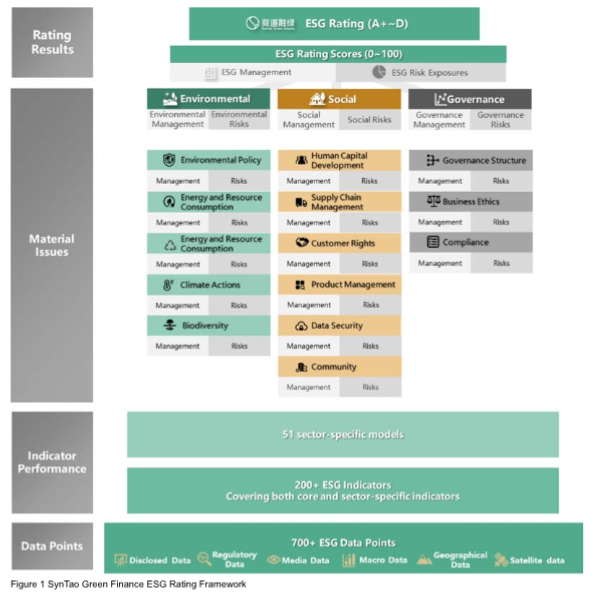

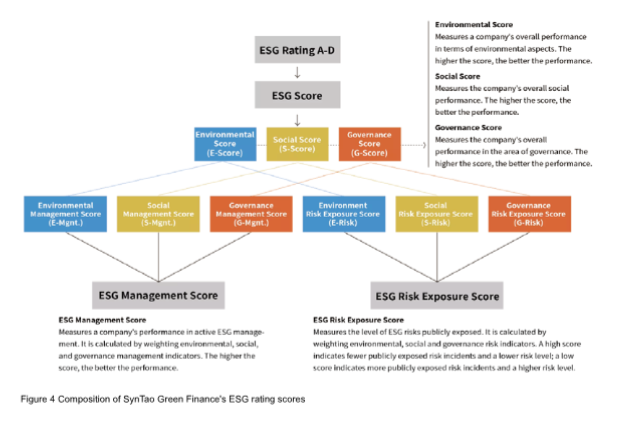
------
**CNRDS**
* Follow International Standard:  
    * Align with International Disclosure: It follows the international disclousre framework such as ISO 260000, GRI Standard, and SASB standard. 
    * Build upon and qantitaive and qualitie data. 
    * It includes 14 ESG Topics, 39 sub-indicators, 44 underlying variables, 
* Industry Differnce: 
    * Expert doing pairwise comparison -> Scoring Matrix > Consistency Test > Result 
    * Also applied industry-specific standaridzation. 
    * Adjust based on CSRS industry classification (19 Level I Industry) 
* Scoring Mechanism: 
    * Expert doing pairwise comparison -> Scoring Matrix > Consistency Test 
* Data Source: corporate annual and CSR/ESG reports, CNRDS financial and patent databases, media reports, and regulatory filings

**CSMAR v.s. CNSRD Level II Topic Difference**  
    
| Dimension | **CSMAR (SynTao Green Finance)** | **CNRDS ESG-R** |
|------------|----------------------------------|------------------|
| **Environmental (E)** | - Environmental Policy V <br> - Energy and Resource Consumption V <br> - Pollutant Discharge  <br> - Climate Actions  <br> - Biodiversity V| - Climate Change  <br> - Pollution Control  <br> - Circular Economy V <br> - Environmental Risk |
| **Social (S)** | - Human Capital Development V <br> - Customer Rights V <br> - Supply Chain Management V <br> - Data Security V <br> - Product Management  <br> - Community | - Employee Rights  <br> - Product Responsibility  <br> - Social Contribution V <br> - Research and Innovation V <br> - Health and Safety V  <br> - Social Risk |
| **Governance (G)** | - Governance Structure  <br> - Business Ethics V <br> - Compliance V| - Financial Performance V <br> - Corporate Governance  <br> - Information Disclosure V <br> - Governance Risk |


V: This topics only includes in this Rating System. 
While both standards cover core E, S, and G dimensions, CSMAR places a distinct emphasis on policy and foundational aspects, notably featuring:
* Environmental Policy
* Energy and Resource Consumption
* Biodiversity
* Various social pillars like Human Capital Development, Customer Rights, Supply Chain Management, and Data Security
* Governance aspects of Business Ethics and Compliance

In contrast, the CNRDS ESG-R standard appears more focused on tangible impacts, performance, and risk management. Its unique elements include:
* Specific environmental themes like Circular Economy
* Social factors such as Social Contribution, Research and Innovation, and Health and Safety
* Governance metrics directly tied to Financial Performance and Information Disclosure
* A pronounced emphasis on risk across all dimensions, explicitly listing Environmental Risk, Social Risk, and Governance Risk

In essence, CSMAR seems to prioritize the existence of policies and management systems, whereas CNRDS ESG-R leans towards evaluating concrete outcomes, performance results, and the management of associated risks.


### Standardized the Score: 

#### Method 1: Percentile 
* Standardize using Percentile → Show differences at the "ranking level"

In [54]:
# Standardized According to Percentile 
# Percentile for Different Years
df["CNRDS_ESG_pct"] = df.groupby("Year")["ESG_CNRDS"].rank(pct=True)
df["CSMAR_ESG_pct"] = df.groupby("Year")["ESG_CSMAR"].rank(pct=True)
df["CNRDS_E_pct"] = df.groupby("Year")["E_CNRDS"].rank(pct=True)
df["CSMAR_E_pct"] = df.groupby("Year")["E_CSMAR"].rank(pct=True)
df["CNRDS_S_pct"] = df.groupby("Year")["S_CNRDS"].rank(pct=True)
df["CSMAR_S_pct"] = df.groupby("Year")["S_CSMAR"].rank(pct=True)
df["CNRDS_G_pct"] = df.groupby("Year")["G_CNRDS"].rank(pct=True)
df["CSMAR_G_pct"] = df.groupby("Year")["G_CSMAR"].rank(pct=True)


# Two Systems + Four Dimensions
def pct_rank(g, col):
    return g[col].rank(pct=True, method="average")

cols_map = {
    "CSMAR": {"ESG": "ESG_CSMAR", "E": "E_CSMAR", "S": "S_CSMAR", "G": "G_CSMAR"},
    "CNRDS": {"ESG": "ESG_CNRDS", "E": "E_CNRDS", "S": "S_CNRDS", "G": "G_CNRDS"},
}

# 1) Year + Indstury  percentile（Comparable Within Industsry）
for sys, m in cols_map.items():
    for dim, col in m.items():
        df[f"{sys}_{dim}_ind_pct"] = (
            df.groupby(["Year", "CSMAR_Industry_1"], group_keys=False)
              .apply(lambda g: pct_rank(g, col))
        )

# 2) Year percentile（Comparable Across Market）
for sys, m in cols_map.items():
    for dim, col in m.items():
        df[f"{sys}_{dim}_year_pct"] = df.groupby("Year")[col].rank(pct=True, method="average")

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1135000633.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pct_rank(g, col))
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1135000633.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pct_rank(g, col))
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1135000633.py:27: DeprecationWarning: DataFrameGroupBy.apply oper

#### Method 2: Max - Min * 100
* Standardize using Z-score → Show differences at the "structural source" level


In [56]:
# Max-Min Standardization for Different Years
def max_min_standardize(g, col):
    return (g[col] - g[col].min()) / (g[col].max() - g[col].min())

# Max-Min Standardization for Different Years
df["CNRDS_ESG_MM"] = df.groupby("Year")["ESG_CNRDS"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CSMAR_ESG_MM"] = df.groupby("Year")["ESG_CSMAR"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CNRDS_E_MM"] = df.groupby("Year")["E_CNRDS"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CSMAR_E_MM"] = df.groupby("Year")["E_CSMAR"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CNRDS_S_MM"] = df.groupby("Year")["S_CNRDS"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CSMAR_S_MM"] = df.groupby("Year")["S_CSMAR"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CNRDS_G_MM"] = df.groupby("Year")["G_CNRDS"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df["CSMAR_G_MM"] = df.groupby("Year")["G_CSMAR"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Two Systems + Four Dimensions
cols_map = {
    "CSMAR": {"ESG": "ESG_CSMAR", "E": "E_CSMAR", "S": "S_CSMAR", "G": "G_CSMAR"},
    "CNRDS": {"ESG": "ESG_CNRDS", "E": "E_CNRDS", "S": "S_CNRDS", "G": "G_CNRDS"},
}

# 1) Year + Industry Max-Min Standardization (Comparable Within Industry)
for sys, m in cols_map.items():
    for dim, col in m.items():
        df[f"{sys}_{dim}_ind_MM"] = (
            df.groupby(["Year", "CSMAR_Industry_1"], group_keys=False)
              .apply(lambda g: max_min_standardize(g, col))
        )

# 2) Year Max-Min Standardization (Comparable Across Market)
for sys, m in cols_map.items():
    for dim, col in m.items():
        df[f"{sys}_{dim}_year_MM"] = (
            df.groupby("Year", group_keys=False)
              .apply(lambda g: max_min_standardize(g, col))
        )

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1792275454.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: max_min_standardize(g, col))
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1792275454.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: max_min_standardize(g, col))
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1792275454.py:26: DeprecationWarning: DataF

In [57]:
DIMS = ["ESG", "E", "S", "G"]
IND_COL = "CSMAR_Industry"   # Industry listing; please modify here if there are any discrepancies.

def per_industry_tests(df, dim, industry_col=IND_COL):
    """Perform paired difference tests on individual dimensions (ESG/E/S/G) within each industry and return the industry-specific results table."""
    c_col = f"CSMAR_{dim}_ind_pct"
    n_col = f"CNRDS_{dim}_ind_pct"
    use = df[[industry_col, c_col, n_col]].dropna().copy()

    # Company-level industry percentile difference (positive = CSMAR is higher)
    use["diff"] = use[c_col] - use[n_col]

    # Industry aggregation statistics
    def _agg(g):
        x = g["diff"].values
        n = len(x)
        mean_ = float(np.mean(x))
        std_  = float(np.std(x, ddof=1)) if n > 1 else np.nan

        # One-sample t-test: Does the mean significantly deviate from 0?
        try:
            t_stat, p_t = stats.ttest_1samp(x, popmean=0.0, alternative="two-sided")
        except Exception:
            t_stat, p_t = (np.nan, np.nan)

        # Wilcoxon (non-parametric), requires at least one non-zero value; n >= 10 provides more reliable results.
        try:
            if np.allclose(x, 0) or n < 5:
                w_stat, p_w = (np.nan, np.nan)
            else:
                w_stat, p_w = stats.wilcoxon(x, alternative="two-sided", zero_method="wilcox")
        except Exception:
            w_stat, p_w = (np.nan, np.nan)

        return pd.Series({
            "n": n,
            "mean_diff(CSMAR-CNRDS)": mean_,
            "std_diff": std_,
            "t_stat": t_stat, "t_p": p_t,
            "wilcoxon_p": p_w
        })

    out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
    # Sorting: By absolute mean difference
    out["abs_mean_diff"] = out["mean_diff(CSMAR-CNRDS)"].abs()
    out = out.sort_values(["abs_mean_diff", "n"], ascending=[False, False])

    return out, use  # Returns industry-level data & company-level differences (for plotting purposes)

# Main process: Calculations are performed across four dimensions, and an overview table is generated (showing the top industries with the greatest differences) 
per_dim_tables = {}
summary_rows = []

TOPK = 10  # For each dimension, select the top K industries with the largest differences for an overall overview.

for dim in DIMS:
    ind_table, firm_diff = per_industry_tests(df, dim)
    per_dim_tables[dim] = ind_table

    # Summarize the top differentiating industries.
    topk = ind_table.head(TOPK).copy()
    topk.insert(0, "Dimension", dim)
    summary_rows.append(topk)

industry_diff_summary = pd.concat(summary_rows, ignore_index=True)

# Print results: Dimensions → Industry Differences Top K
print("Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):\n")
display(industry_diff_summary[[
    "Dimension", IND_COL, "n", "mean_diff(CSMAR-CNRDS)",
    "std_diff", "t_stat", "t_p", "wilcoxon_p"
]])


C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\875733430.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):



C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\875733430.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

Dimension                                    CSMAR_Industry     n  \
0        ESG                                   Postal Services  11.0   
1        ESG        Manufacture of Rubber and Plastic Products   2.0   
2        ESG    Manufacture of Chemicals and Chemical Products  31.0   
3        ESG      Processing of Agricultural and Sideline Food  20.0   
4        ESG                     Support Activities for Mining  11.0   
5        ESG        Scientific Research and Technical Services   2.0   
6        ESG                  Textile, Apparel and Accessories   8.0   
7        ESG                                    Road Transport   2.0   
8        ESG                                     Comprehensive   8.0   
9        ESG            Smelting and Rolling of Ferrous Metals  26.0   
10         E      Processing of Agricultural and Sideline Food  20.0   
11         E        Scientific Research and Technical Services   2.0   
12         E                     Support Activities for Mining  11.0   
13         E                   Food and Essential Goods Retail   1.0   
14         E                                     Comprehensive   8.0   
15         E                 Ferrous Metal Mining and Dressing   1.0   
16         E                       Water Production and Supply   2.0   
17         E  Processing of Petroleum, Coking and Nuclear Fuel   7.0   
18         E                                   Postal Services  11.0   
19         E            Smelting and Rolling of Ferrous Metals  26.0   
20         S                                   Postal Services  11.0   
21         S           Manufacture of Paper and Paper Products   1.0   
22         S                                           Leasing   1.0   
23         S        Manufacture of Rubber and Plastic Products   2.0   
24         S                   Food and Essential Goods Retail   1.0   
25         S                  Textile, Apparel and Accessories   8.0   
26         S                               News and Publishing   9.0   
27         S    Manufacture of Chemicals and Chemical Products  31.0   
28         S                                   Water Transport  29.0   
29         S                                          Delisted   1.0   
30         G                                           Leasing   1.0   
31         G                         Gas Production and Supply   2.0   
32         G        Manufacture of Rubber and Plastic Products   2.0   
33         G           Manufacture of Paper and Paper Products   1.0   
34         G                                      Construction   6.0   
35         G                                   Postal Services  11.0   
36         G                                  Culture and Arts   6.0   
37         G  Processing of Petroleum, Coking and Nuclear Fuel   7.0   
38         G                   Food and Essential Goods Retail   1.0   
39         G                                    Rail Transport   9.0   

    mean_diff(CSMAR-CNRDS)  std_diff     t_stat           t_p  wilcoxon_p  
0                -0.546717  0.255818  -7.088082  3.342648e-05    0.001953  
1                -0.520000  0.509117  -1.444444  3.855017e-01         NaN  
2                -0.395438  0.369968  -5.951068  1.598760e-06    0.000010  
3                -0.386666  0.274189  -6.306680  4.710977e-06    0.000004  
4                 0.377491  0.289579   4.323508  1.504809e-03    0.004883  
5                 0.366667  0.612826   0.846154  5.529294e-01         NaN  
6                -0.321400  0.239374  -3.797641  6.735458e-03    0.007812  
7                 0.310764  0.046649   9.421053  6.732209e-02         NaN  
8                -0.297619  0.364577  -2.308961  5.426978e-02    0.078125  
9                 0.291274  0.368953   4.025477  4.640520e-04    0.000465  
10               -0.498126  0.305452  -7.293078  6.437802e-07    0.000013  
11                0.483333  0.306413   2.230769  2.682838e-01         NaN  
12                0.465942  0.312058   4.952142  5.767013e-04 

1. Correlation Analysis:
* Calculate Spearman/Pearson correlation coefficients (to measure consistency).
* If consistency changes are observed across different years or industries, display charts (heatmap/scatter plot).
2. Group Comparison (by industry or size):
* For example, comparing state-owned enterprises/private enterprises, large-cap/small-cap companies;
* Check if the difference between the two sets of ESG scores is consistent across different groups (two-way ANOVA).
3. Distribution Testing:
* Use KS test and Q-Q plots to compare distribution differences;
* Explain whether the two systems systematically "overestimate" or "underestimate" certain types of companies.
4. Robustness Testing:
* Use different periods and different samples to see if the differences still exist.

### Show the Difference

#### Correlation Test

##### Different Year

In [69]:
# Correlation Test
dims = ["ESG", "E", "S", "G"]

results_year = []

for year, sub in df.groupby("Year"):
    for dim in dims:
        cn = f"CNRDS_{dim}_pct"
        cs = f"CSMAR_{dim}_pct"
        temp = sub[[cn, cs]].dropna()
        if len(temp) >= 10:
            spearman = spearmanr(temp[cn], temp[cs])[0]
            pearson = pearsonr(temp[cn], temp[cs])[0]
        else:
            spearman, pearson = np.nan, np.nan
        results_year.append({"Year": year, "Dimension": dim, "Spearman": spearman, "Pearson": pearson, "N": len(temp)})

corr_year_df = pd.DataFrame(results_year)
corr_year_df


Year Dimension  Spearman   Pearson    N
0   2015       ESG -0.002337 -0.002337  284
1   2015         E  0.050496  0.050496  284
2   2015         S  0.033857  0.033857  284
3   2015         G  0.018481  0.018481  284
4   2016       ESG  0.035158  0.035158  296
5   2016         E  0.008563  0.008563  296
6   2016         S -0.041625 -0.041625  296
7   2016         G  0.075399  0.075399  296
8   2017       ESG -0.003761 -0.003761  291
9   2017         E  0.069895  0.069895  291
10  2017         S -0.035385 -0.035385  291
11  2017         G  0.150432  0.150432  291
12  2018       ESG  0.011389  0.011389  297
13  2018         E  0.116606  0.116606  297
14  2018         S  0.023522  0.023522  297
15  2018         G  0.193964  0.193964  297
16  2019       ESG  0.064502  0.064502  298
17  2019         E  0.220917  0.220917  298
18  2019         S -0.037883 -0.037883  298
19  2019         G  0.195952  0.195952  298
20  2020       ESG  0.078777  0.078777  317
21  2020         E  0.077308  0.077308  317
22  2020         S -0.083523 -0.083523  317
23  2020         G  0.006922  0.006922  317

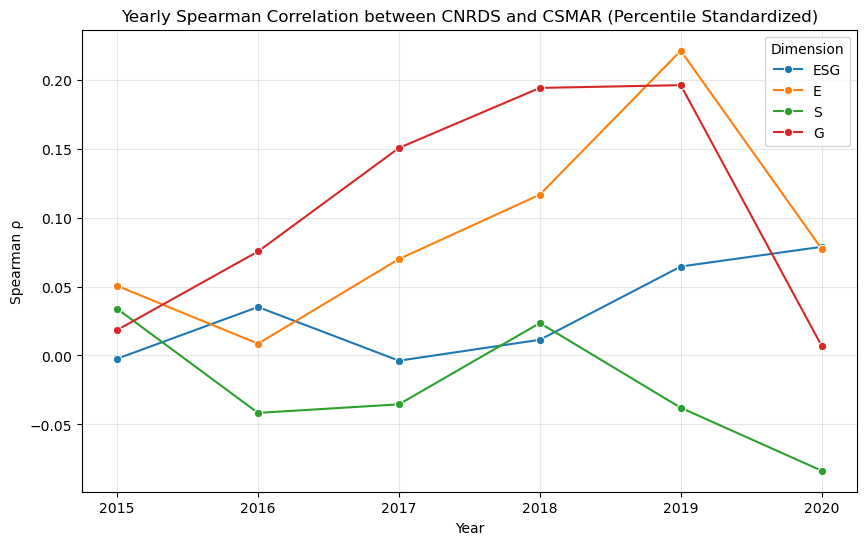

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=corr_year_df, x="Year", y="Spearman", hue="Dimension", marker="o")
plt.title("Yearly Spearman Correlation between CNRDS and CSMAR (Percentile Standardized)")
plt.ylabel("Spearman ρ")
plt.xlabel("Year")
plt.legend(title="Dimension")
plt.grid(alpha=0.3)
plt.show()


#### Industry 

In [81]:
dims = ["ESG", "E", "S", "G"]
MIN_N = 5  # Threshold

results = []

for (year, industry), sub in df.groupby(["Year", "CSMAR_Industry"]):
    for dim in dims:
        cn = f"CNRDS_{dim}_ind_pct"
        cs = f"CSMAR_{dim}_ind_pct"
        tmp = sub[[cn, cs]].dropna()
        n = len(tmp)
        
        # If the sample size is too small, write 0 directly. 
        if n < MIN_N or tmp[cn].nunique() < 2 or tmp[cs].nunique() < 2:
            rho, r = 0, 0
        else:
            rho = spearmanr(tmp[cn], tmp[cs]).correlation
            r = pearsonr(tmp[cn], tmp[cs]).statistic
        
        results.append({
            "Year": year,
            "Industry": industry,
            "Dimension": dim,
            "Spearman": rho,
            "Pearson": r,
            "N": n
        })

corr_ind_df = pd.DataFrame(results)
corr_ind_df.to_excel("industry_year_correlation_MIN5_zero.xlsx", index=False)
corr_ind_df


Year                                     Industry Dimension  Spearman  \
0    2015                                  Agriculture       ESG  0.000000   
1    2015                                  Agriculture         E  0.000000   
2    2015                                  Agriculture         S  0.000000   
3    2015                                  Agriculture         G  0.000000   
4    2015                                Air Transport       ESG -0.657143   
..    ...                                          ...       ...       ...   
899  2020  Transportation, Storage and Postal Services         G -0.175568   
900  2020                   Wholesale and Retail Trade       ESG -0.173931   
901  2020                   Wholesale and Retail Trade         E -0.376851   
902  2020                   Wholesale and Retail Trade         S -0.600000   
903  2020                   Wholesale and Retail Trade         G  0.142857   

      Pearson   N  
0    0.000000   2  
1    0.000000   2  
2    0.000000   2  
3    0.000000   2  
4   -0.666366   6  
..        ...  ..  
899 -0.175568  17  
900  0.050303   6  
901 -0.318293   6  
902 -0.679431   6  
903  0.134339   6  

[904 rows x 6 columns]

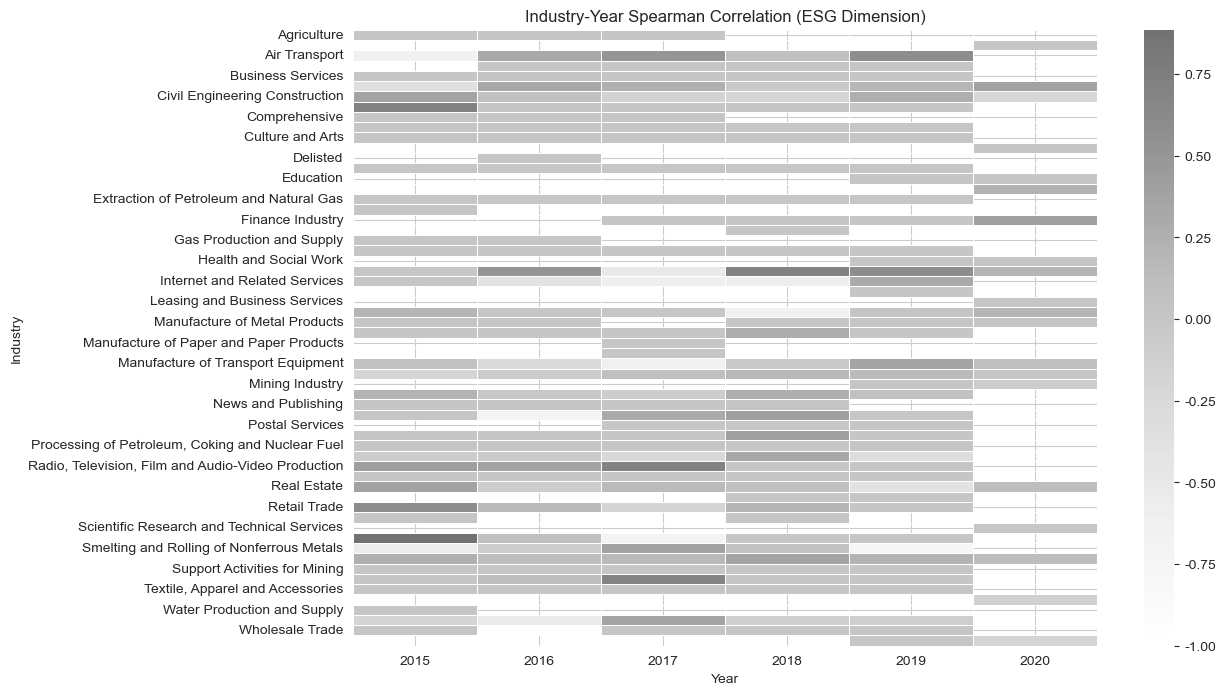

In [83]:
pivot = corr_ind_df[corr_ind_df["Dimension"] == "ESG"].pivot(index="Industry", columns="Year", values="Spearman")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap="Greys", center=0.5, linewidths=0.5, annot=False)
plt.title("Industry-Year Spearman Correlation (ESG Dimension)")
plt.xlabel("Year")
plt.ylabel("Industry")
plt.show()


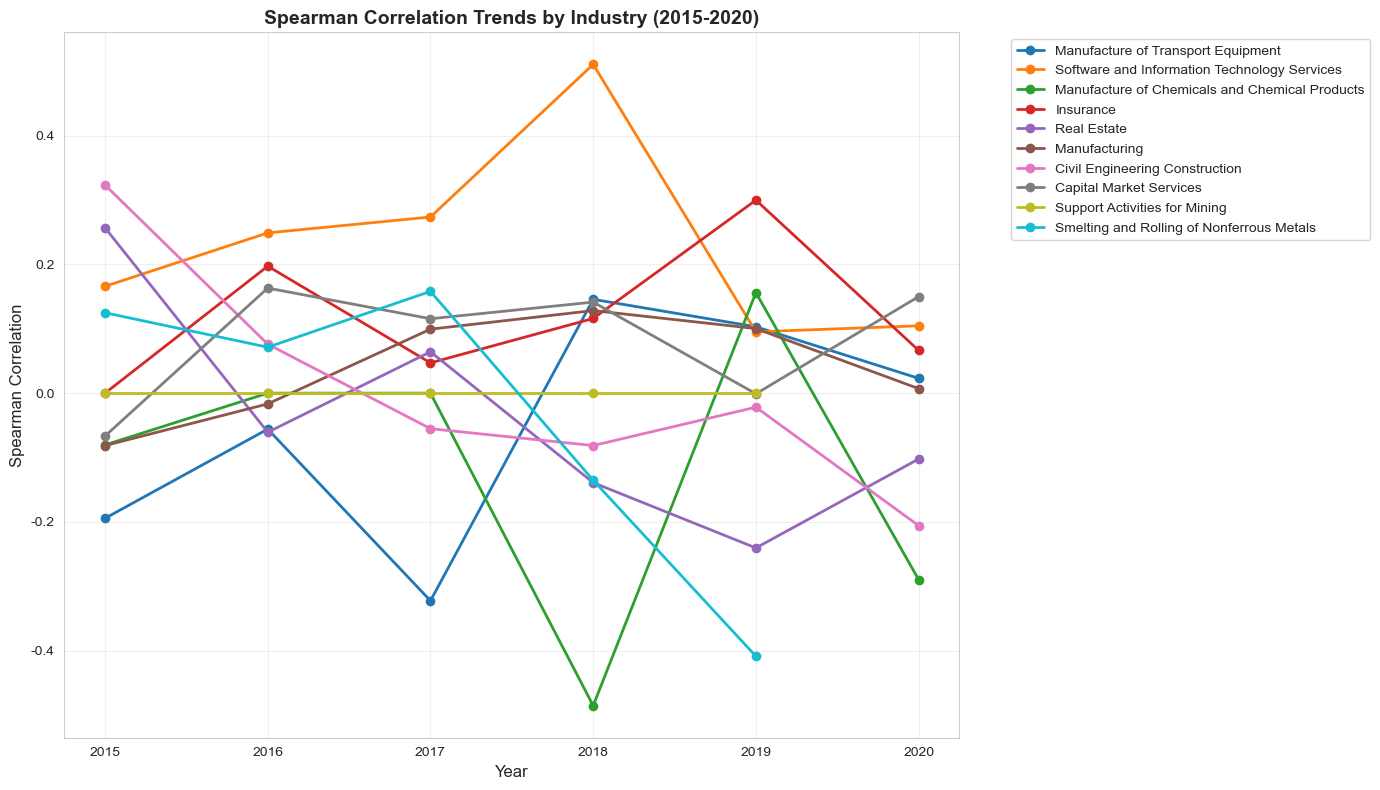

Year Range: 2015 - 2020


In [85]:
# Copy and process the data.
plot_data = corr_ind_df.copy()

# Remove rows where the Spearman correlation is NaN.
plot_data = plot_data.dropna(subset=['Spearman'])

# Create a graphic
plt.figure(figsize=(14, 8))

# Get the list of industries (you can select specific industries or all of them)
# Choose industries with a larger amount of data to display, to avoid the graph becoming too cluttered.
industry_counts = plot_data['Industry'].value_counts()

# Select the top 10 industries with the highest number of occurrences; you can adjust this number.
top_industries = industry_counts.head(10).index

# Filtering data
filtered_data = plot_data[plot_data['Industry'].isin(top_industries)]

# Calculate the average Spearman correlation coefficient by year and industry.
yearly_industry_avg = filtered_data.groupby(['Year', 'Industry'])['Spearman'].mean().reset_index()

# Draw a line graph
for industry in top_industries:
    industry_data = yearly_industry_avg[yearly_industry_avg['Industry'] == industry]
    plt.plot(industry_data['Year'], industry_data['Spearman'], 
             marker='o', linewidth=2, markersize=6, label=industry)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Spearman Correlation', fontsize=12)
plt.title('Spearman Correlation Trends by Industry (2015-2020)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display statistical data
print(f"Year Range: {plot_data['Year'].min()} - {plot_data['Year'].max()}")

In [91]:
# strong positive
strong_pos = corr_ind_df[corr_ind_df["Spearman"] > 0.5]
# strong negative
strong_neg = corr_ind_df[corr_ind_df["Spearman"] < -0.5]

print("Strong Positive Correlations (>0.5):")
display(strong_pos[["Year", "Industry", "Dimension", "Spearman", "N"]].head(5))

print("Strong Negative Correlations (<-0.5):")
display(strong_neg[["Year", "Industry", "Dimension", "Spearman", "N"]].head(5))


Strong Positive Correlations (>0.5):


Year                                           Industry Dimension  \
7    2015                                      Air Transport         G   
20   2015                            Coal Mining and Washing       ESG   
23   2015                            Coal Mining and Washing         G   
66   2015     Manufacture of Chemicals and Chemical Products         S   
110  2015  Radio, Television, Film and Audio-Video Produc...         S   

     Spearman  N  
7    0.608760  6  
20   0.714286  6  
23   0.771429  6  
66   0.579771  6  
110  0.700000  5

Strong Negative Correlations (<-0.5):


Year                                        Industry Dimension  Spearman  \
4    2015                                   Air Transport       ESG -0.657143   
65   2015  Manufacture of Chemicals and Chemical Products         E -0.608760   
95   2015            Nonferrous Metal Mining and Dressing         G -0.892857   
121  2015                                    Retail Trade         E -0.707107   
132  2015       Smelting and Rolling of Nonferrous Metals       ESG -0.547619   

     N  
4    6  
65   6  
95   7  
121  5  
132  8

In [93]:
# Strong Positive Analysis
print("Strong Positive Correlations - Industry Dimension Count:")

# Group by Year and Industry, and calculate the number of dimensions and the specific dimensions for each industry.
strong_pos_summary = strong_pos.groupby(['Year', 'Industry']).agg({
    'Dimension': ['count', lambda x: list(x.unique())]
}).reset_index()

strong_pos_summary.columns = ['Year', 'Industry', 'Dimension_Count', 'Dimensions']
strong_pos_summary = strong_pos_summary.sort_values(['Year', 'Dimension_Count'], ascending=[True, False])

display(strong_pos_summary)

print("\n" + "="*80 + "\n")

# Strong Negative Analysis
print("Strong Negative Correlations - Industry Dimension Count:")

if not strong_neg.empty:
    strong_neg_summary = strong_neg.groupby(['Year', 'Industry']).agg({
        'Dimension': ['count', lambda x: list(x.unique())]
    }).reset_index()
    
    strong_neg_summary.columns = ['Year', 'Industry', 'Dimension_Count', 'Dimensions']
    strong_neg_summary = strong_neg_summary.sort_values(['Year', 'Dimension_Count'], ascending=[True, False])
    
    display(strong_neg_summary)
else:
    print("No strong negative correlations found.")

Strong Positive Correlations - Industry Dimension Count:


Year                                           Industry  Dimension_Count  \
5   2015                                       Retail Trade                3   
6   2015             Smelting and Rolling of Ferrous Metals                3   
1   2015                            Coal Mining and Washing                2   
0   2015                                      Air Transport                1   
2   2015     Manufacture of Chemicals and Chemical Products                1   
3   2015  Radio, Television, Film and Audio-Video Produc...                1   
4   2015                                        Real Estate                1   
7   2015          Smelting and Rolling of Nonferrous Metals                1   
8   2015       Software and Information Technology Services                1   
9   2015                                    Water Transport                1   
10  2016                                      Air Transport                1   
11  2016                 Manufacture of Transport Equipment                1   
12  2016               Nonferrous Metal Mining and Dressing                1   
13  2016  Radio, Television, Film and Audio-Video Produc...                1   
14  2016       Software and Information Technology Services                1   
15  2016                                    Wholesale Trade                1   
18  2017  Radio, Television, Film and Audio-Video Produc...                2   
20  2017  Telecommunications, Broadcasting and Satellite...                2   
16  2017                                      Air Transport                1   
17  2017      Production and Supply of Electricity and Heat                1   
19  2017       Software and Information Technology Services                1   
21  2018                                          Insurance                2   
27  2018       Software and Information Technology Services                2   
22  2018                 Manufacture of Transport Equipment                1   
23  2018               Nonferrous Metal Mining and Dressing                1   
24  2018      Production and Supply of Electricity and Heat                1   
25  2018                                       Retail Trade                1   
26  2018             Smelting and Rolling of Ferrous Metals                1   
29  2019                                          Insurance                2   
28  2019                                      Air Transport                1   
30  2019                      Internet and Related Services                1   
31  2019     Manufacture of Chemicals and Chemical Products                1   
32  2019       Manufacture of Non-metallic Mineral Products                1   
33  2019       Software and Information Technology Services                1   
34  2019                                    Water Transport                1   
35  2020                                    Mining Industry                1   

     Dimensions  
5   [ESG, S, G]  
6   [ESG, S, G]  
1      [ESG, G]  
0           [G]  
2           [S]  
3           [S]  
4           [E]  
7           [S]  
8           [E]  
9           [G]  
10          [E]  
11          [G]  
12          [S]  
13          [E]  
14          [E]  
15          [G]  
18     [ESG, E]  
20     [ESG, G]  
16          [G]  
17          [S]  
19          [E]  
21     [ESG, E]  
27       [E, S]  
22          [S]  
23          [S]  
24          [G]  
25          [G]  
26          [G]  
29     [ESG, G]  
28        [ESG]  
30          [S]  
31          [S]  
32          [G]  
33          [E]  
34          [G]  
35          [S]



Strong Negative Correlations - Industry Dimension Count:


Year                                           Industry  Dimension_Count  \
0   2015                                      Air Transport                1   
1   2015     Manufacture of Chemicals and Chemical Products                1   
2   2015               Nonferrous Metal Mining and Dressing                1   
3   2015                                       Retail Trade                1   
4   2015          Smelting and Rolling of Nonferrous Metals                1   
5   2016                                      Air Transport                1   
6   2016                                  Business Services                1   
7   2016                      Internet and Related Services                1   
8   2016                 Manufacture of Transport Equipment                1   
9   2016               Nonferrous Metal Mining and Dressing                1   
10  2016                                       Retail Trade                1   
11  2016             Smelting and Rolling of Ferrous Metals                1   
12  2016  Telecommunications, Broadcasting and Satellite...                1   
13  2016                                    Water Transport                1   
14  2016                                    Wholesale Trade                1   
15  2017                      Internet and Related Services                2   
18  2017             Smelting and Rolling of Ferrous Metals                2   
16  2017                 Manufacture of Transport Equipment                1   
17  2017               Nonferrous Metal Mining and Dressing                1   
21  2018     Manufacture of Chemicals and Chemical Products                2   
24  2018             Smelting and Rolling of Ferrous Metals                2   
19  2018                                          Insurance                1   
20  2018                      Internet and Related Services                1   
22  2018               Nonferrous Metal Mining and Dressing                1   
23  2018                                        Real Estate                1   
28  2019          Smelting and Rolling of Nonferrous Metals                2   
25  2019                      Internet and Related Services                1   
26  2019       Manufacture of Non-metallic Mineral Products                1   
27  2019                                        Real Estate                1   
29  2019       Software and Information Technology Services                1   
30  2019                                    Water Transport                1   
31  2020                     Civil Engineering Construction                1   
32  2020                                          Insurance                1   
33  2020     Manufacture of Chemicals and Chemical Products                1   
34  2020                         Wholesale and Retail Trade                1   

   Dimensions  
0       [ESG]  
1         [E]  
2         [G]  
3         [E]  
4       [ESG]  
5         [S]  
6         [G]  
7         [G]  
8         [S]  
9       [ESG]  
10        [E]  
11        [S]  
12        [S]  
13      [ESG]  
14      [ESG]  
15   [ESG, G]  
18   [ESG, S]  
16      [ESG]  
17        [E]  
21   [ESG, S]  
24     [E, S]  
19        [S]  
20      [ESG]  
22        [G]  
23        [S]  
28   [ESG, E]  
25        [G]  
26        [E]  
27        [S]  
29        [G]  
30        [E]  
31        [G]  
32        [S]  
33        [E]  
34        [S]

In [95]:
# More detailed annual statistics - Strong Positive
print("Strong Positive - Detailed Yearly Industry Analysis:")
yearly_detailed = strong_pos_summary.groupby('Year').agg({
    'Industry': ['count', lambda x: list(x)],
    'Dimension_Count': 'sum'
}).reset_index()

yearly_detailed.columns = ['Year', 'Unique_Industries_Count', 'Industries_List', 'Total_Dimensions_Count']
display(yearly_detailed)

print("\n" + "="*80 + "\n")

# Detailed statistics for Strong Negative (if data is available)
if not strong_neg.empty:
    print("Strong Negative - Detailed Yearly Industry Analysis:")
    yearly_detailed_neg = strong_neg_summary.groupby('Year').agg({
        'Industry': ['count', lambda x: list(x)],
        'Dimension_Count': 'sum'
    }).reset_index()
    
    yearly_detailed_neg.columns = ['Year', 'Unique_Industries_Count', 'Industries_List', 'Total_Dimensions_Count']
    display(yearly_detailed_neg)

Strong Positive - Detailed Yearly Industry Analysis:


Year  Unique_Industries_Count  \
0  2015                       10   
1  2016                        6   
2  2017                        5   
3  2018                        7   
4  2019                        7   
5  2020                        1   

                                     Industries_List  Total_Dimensions_Count  
0  [Retail Trade, Smelting and Rolling of Ferrous...                      15  
1  [Air Transport, Manufacture of Transport Equip...                       6  
2  [Radio, Television, Film and Audio-Video Produ...                       7  
3  [Insurance, Software and Information Technolog...                       9  
4  [Insurance, Air Transport, Internet and Relate...                       8  
5                                  [Mining Industry]                       1



Strong Negative - Detailed Yearly Industry Analysis:


Year  Unique_Industries_Count  \
0  2015                        5   
1  2016                       10   
2  2017                        4   
3  2018                        6   
4  2019                        6   
5  2020                        4   

                                     Industries_List  Total_Dimensions_Count  
0  [Air Transport, Manufacture of Chemicals and C...                       5  
1  [Air Transport, Business Services, Internet an...                      10  
2  [Internet and Related Services, Smelting and R...                       6  
3  [Manufacture of Chemicals and Chemical Product...                       8  
4  [Smelting and Rolling of Nonferrous Metals, In...                       7  
5  [Civil Engineering Construction, Insurance, Ma...                       4

In [97]:
industry_avg = (
    corr_ind_df.groupby(["Industry", "Dimension"])["Spearman"]
    .mean()
    .reset_index()
    .pivot(index="Industry", columns="Dimension", values="Spearman")
)

industry_avg = industry_avg[industry_avg["ESG"] > 0].sort_values("ESG", ascending=False)
display(industry_avg.round(3))

Dimension                                               E    ESG      G      S
Industry                                                                      
Radio, Television, Film and Audio-Video Production  0.278  0.299  0.151  0.219
Insurance                                           0.041  0.250  0.311 -0.117
Electricity, Heat, Gas and Water Supply             0.462  0.217 -0.433  0.051
Software and Information Technology Services        0.623  0.208 -0.171  0.273
Air Transport                                      -0.040  0.169  0.253 -0.214
Telecommunications, Broadcasting and Satellite ... -0.033  0.160  0.213 -0.013
Retail Trade                                       -0.286  0.149  0.429  0.310
Coal Mining and Washing                            -0.017  0.143  0.154 -0.046
Capital Market Services                            -0.102  0.132  0.208  0.097
Finance Industry                                    0.083  0.100 -0.030  0.003
Monetary Financial Services                         0.011  0.090 -0.091  0.041
Processing of Agricultural and Sideline Food        0.000  0.080 -0.092  0.080
Manufacture of Non-metallic Mineral Products       -0.237  0.057  0.157  0.079
Smelting and Rolling of Ferrous Metals             -0.165  0.054  0.449 -0.274
Real Estate                                         0.146  0.044 -0.056 -0.281
Civil Engineering Construction                      0.170  0.023 -0.138 -0.031
Manufacturing                                       0.038  0.019  0.152 -0.051
Business Services                                   0.057  0.010 -0.200 -0.092

In [99]:
dim_avg = corr_ind_df.groupby("Dimension")["Spearman"].mean().round(3)
print("Average Spearman Correlation by Dimension:")
print(dim_avg)

Average Spearman Correlation by Dimension:
Dimension
E      0.003
ESG    0.024
G      0.026
S      0.006
Name: Spearman, dtype: float64


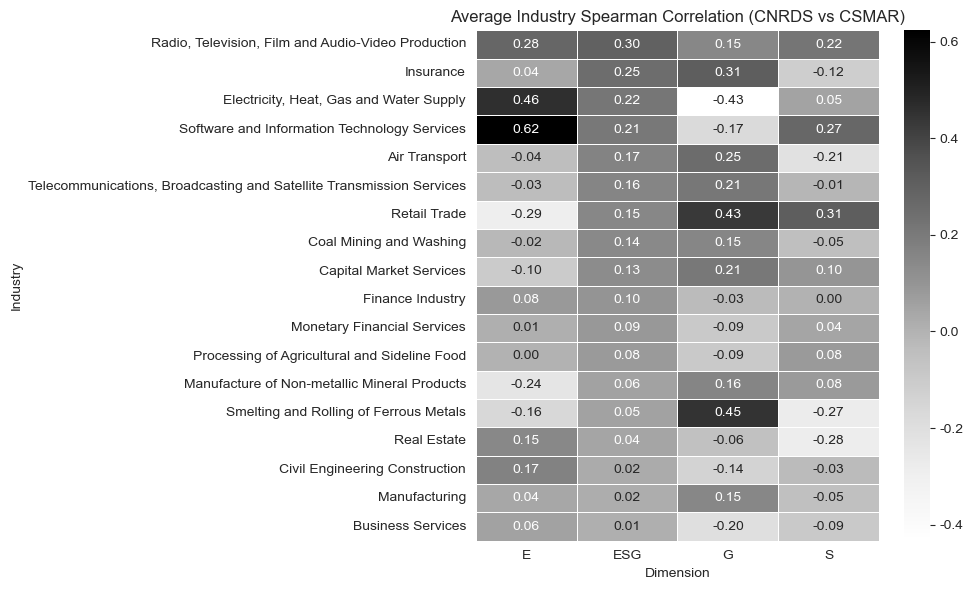

In [107]:
industry_avg_filled = industry_avg.fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(industry_avg_filled, cmap="Greys", linewidths=0.5, annot=True, fmt=".2f")
plt.title("Average Industry Spearman Correlation (CNRDS vs CSMAR)")
plt.xlabel("Dimension")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


#### ANOVA: Prove the Difference is Consistent

#### Difference Effect Model
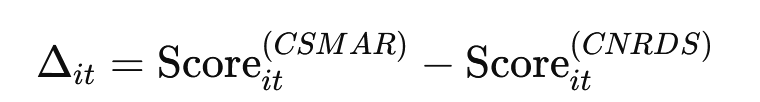
If this is significant different from zero.   

**Difference Test on Data**  
If this is significant different from zero.   
Conduct paired-sample t-tests and Wilcoxon signed-rank tests to compare firm-level scores between the CSMAR and CNRDS ESG rating systems.
* Statistically Significnat: The results show that mean differences across all four dimensions (E, S, G, and overall ESG) are highly significant (p < 0.001).
    * Specifically, CSMAR assigns substantially higher scores than CNRDS in the overall ESG dimension (mean difference = +20.05) and in the Environmental dimension (mean difference = +11.71), while it assigns significantly lower scores in the Governance dimension (mean difference = −15.54) and slightly lower scores in the Social dimension (mean difference = −3.18).
* These results indicate that the two ESG rating systems exhibit systematic scoring discrepancies even after normalization, reflecting distinct methodological orientations.

In [120]:
# Four Dimensions
dims = ["ESG", "E", "S", "G"]
results = []

for dim in dims:
    print(f"\n--- {dim} ---")

    # Extract the standardized score column for the corresponding dimension.
    df_sub = df[[f"{dim}_CSMAR", f"{dim}_CNRDS"]].dropna()

    # Calculate the difference
    diff = df_sub[f"{dim}_CSMAR"] - df_sub[f"{dim}_CNRDS"]

    # Paired T-test
    t_stat, p_val = stats.ttest_rel(df_sub[f"{dim}_CSMAR"], df_sub[f"{dim}_CNRDS"])

    # Wilcoxon test (non-parametric, to address non-normal distribution)
    try:
        w_stat, w_pval = stats.wilcoxon(df_sub[f"{dim}_CSMAR"], df_sub[f"{dim}_CNRDS"])
    except ValueError:
        w_stat, w_pval = (None, None)

    results.append({
        "Dimension": dim,
        "Mean(CSMAR - CNRDS)": diff.mean(),
        "Std.Dev": diff.std(),
        "Paired t-stat": t_stat,
        "t-test p-value": p_val,
        "Wilcoxon p-value": w_pval
    })

# Results Table
result_table = pd.DataFrame(results)
print("\nFirm-level paired test between ESG rating systems (standardized percentile scores)\n")
display(result_table)



--- ESG ---

--- E ---

--- S ---

--- G ---

Firm-level paired test between ESG rating systems (standardized percentile scores)



Dimension  Mean(CSMAR - CNRDS)    Std.Dev  Paired t-stat  t-test p-value  \
0       ESG            20.047270  11.186488      75.672340    0.000000e+00   
1         E            11.709757  17.393566      28.427255   6.625652e-147   
2         S            -3.181554  20.043752      -6.702486    2.740527e-11   
3         G           -15.544725  17.616434     -37.259817   3.423736e-225   

   Wilcoxon p-value  
0     5.867035e-279  
1     1.167812e-149  
2      5.180138e-23  
3     2.299000e-170

**Difference Test on Data After Standardized**  
This is significant different from zero.   
Conduct paired-sample t-tests and Wilcoxon signed-rank tests to compare firm-level standardized percentile scores (0–100) between the CSMAR and CNRDS ESG rating systems.
* Statistically Insignificnat: The results show that mean differences across all four dimensions (E, S, G, and overall ESG) are statistically insignificant (p ≈ 1.0), and the average score differences are near zero.
* This indicates that after normalization, the two ESG rating systems yield nearly identical assessments for the same firms.

In [126]:
# Four Dimensions
dims = ["ESG", "E", "S", "G"]
results = []

for dim in dims:
    print(f"\n{dim}")

    # Extract the standardized score column for the corresponding dimension.
    df_sub = df[[f"CSMAR_{dim}_pct", f"CNRDS_{dim}_pct"]].dropna()

    # Calculate the difference
    diff = df_sub[f"CSMAR_{dim}_pct"] - df_sub[f"CNRDS_{dim}_pct"]

    # Paired-samples t-test
    t_stat, p_val = stats.ttest_rel(df_sub[f"CSMAR_{dim}_pct"], df_sub[f"CNRDS_{dim}_pct"])

    # Wilcoxon test (non-parametric, to address non-normal distribution)
    try:
        w_stat, w_pval = stats.wilcoxon(df_sub[f"CSMAR_{dim}_pct"], df_sub[f"CNRDS_{dim}_pct"])
    except ValueError:
        w_stat, w_pval = (None, None)

    results.append({
        "Dimension": dim,
        "Mean(CSMAR - CNRDS)": diff.mean(),
        "Std.Dev": diff.std(),
        "Paired t-stat": t_stat,
        "t-test p-value": p_val,
        "Wilcoxon p-value": w_pval
    })

# Results Table
result_table = pd.DataFrame(results)
print("\nFirm-level paired test between ESG rating systems (standardized percentile scores)\n")
display(result_table)



ESG

E

S

G

Firm-level paired test between ESG rating systems (standardized percentile scores)



Dimension  Mean(CSMAR - CNRDS)   Std.Dev  Paired t-stat  t-test p-value  \
0       ESG        -5.977645e-18  0.401858  -6.281066e-16             1.0   
1         E        -2.490685e-18  0.389254  -2.701852e-16             1.0   
2         S         4.981371e-19  0.413270   5.089680e-17             1.0   
3         G         0.000000e+00  0.386008   0.000000e+00             1.0   

   Wilcoxon p-value  
0          0.468202  
1          0.276757  
2          0.835673  
3          0.569776

**Difference According to Year**  
No significant difference. 

* Paired-sample t-tests and Wilcoxon signed-rank tests based on year-standardized percentile scores show no significant differences between the CSMAR and CNRDS ESG ratings across all years (2015–2020) and all dimensions (E, S, G, and overall ESG), with p-values equal to 1.0.
* This indicates that after normalization by year, the two ESG rating systems exhibit highly stable and consistent scoring patterns over time.
* Therefore, temporal variation is not a major source of divergence between the two systems; instead, rating discrepancies primarily originate from industry-level heterogeneity rather than year-to-year methodological changes.

In [128]:
DIMS = ["ESG", "E", "S", "G"]
YEAR_COL = "Year"   

def per_year_tests(df, dim, year_col=YEAR_COL):
    """Perform paired difference tests on each individual dimension (ESG/E/S/G) by year."""
    c_col = f"CSMAR_{dim}_year_pct"
    n_col = f"CNRDS_{dim}_year_pct"

    use = df[[year_col, c_col, n_col]].dropna().copy()
    use["diff"] = use[c_col] - use[n_col]

    def _agg(g):
        x = g["diff"].values
        n = len(x)
        mean_ = float(np.mean(x))
        std_  = float(np.std(x, ddof=1)) if n > 1 else np.nan

        try:
            t_stat, p_t = stats.ttest_1samp(x, popmean=0.0)
        except Exception:
            t_stat, p_t = (np.nan, np.nan)

        try:
            if np.allclose(x, 0) or n < 5:
                w_stat, p_w = (np.nan, np.nan)
            else:
                w_stat, p_w = stats.wilcoxon(x)
        except Exception:
            w_stat, p_w = (np.nan, np.nan)

        return pd.Series({
            "n": n,
            "mean_diff(CSMAR-CNRDS)": mean_,
            "std_diff": std_,
            "t_stat": t_stat,
            "t_p": p_t,
            "wilcoxon_p": p_w
        })

    out = use.groupby(year_col, as_index=False).apply(_agg).reset_index(drop=True)
    out["abs_mean_diff"] = out["mean_diff(CSMAR-CNRDS)"].abs()
    return out


# Main process: Perform the process separately for each of the four dimensions: ESG, E, S, and G.
per_year_tables = {}
summary_rows = []

for dim in DIMS:
    year_table = per_year_tests(df, dim)
    per_year_tables[dim] = year_table

    tmp = year_table.copy()
    tmp.insert(0, "Dimension", dim)
    summary_rows.append(tmp)

year_diff_summary = pd.concat(summary_rows, ignore_index=True)

print("\nYear-level differences between CSMAR and CNRDS (year-standardized percentiles):\n")
display(year_diff_summary[[
    "Dimension", YEAR_COL, "n",
    "mean_diff(CSMAR-CNRDS)", "std_diff", "t_stat", "t_p", "wilcoxon_p"
]])



Year-level differences between CSMAR and CNRDS (year-standardized percentiles):



C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\3155122643.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = use.groupby(year_col, as_index=False).apply(_agg).reset_index(drop=True)
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\3155122643.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = use.groupby(year_col, as_index=False).apply(_agg).reset_index(drop=True)
C:\Users\wanyi\AppData\Loc

Dimension  Year      n  mean_diff(CSMAR-CNRDS)  std_diff        t_stat  \
0        ESG  2015  284.0           -1.563694e-18  0.409431 -6.436215e-17   
1        ESG  2016  296.0           -2.250452e-18  0.401670 -9.639322e-17   
2        ESG  2017  291.0            6.104319e-18  0.409704  2.541640e-16   
3        ESG  2018  297.0            0.000000e+00  0.406588  0.000000e+00   
4        ESG  2019  298.0           -5.960929e-18  0.395513 -2.601725e-16   
5        ESG  2020  317.0            2.801825e-18  0.392446  1.271132e-16   
6          E  2015  284.0            5.472930e-18  0.398343  2.315376e-16   
7          E  2016  296.0            2.250452e-18  0.407052  9.511855e-17   
8          E  2017  291.0            0.000000e+00  0.394279  0.000000e+00   
9          E  2018  297.0           -9.719124e-18  0.384286 -4.358643e-16   
10         E  2019  298.0           -3.353023e-18  0.360895 -1.603848e-16   
11         E  2020  317.0            1.400912e-18  0.392752  6.350707e-17   
12         S  2015  284.0           -3.127389e-18  0.401844 -1.311547e-16   
13         S  2016  296.0            6.001206e-18  0.417243  2.474543e-16   
14         S  2017  291.0            0.000000e+00  0.416047  0.000000e+00   
15         S  2018  297.0            7.476249e-19  0.404041  3.188867e-17   
16         S  2019  298.0            6.333487e-18  0.416550  2.624727e-16   
17         S  2020  317.0            0.000000e+00  0.425618  0.000000e+00   
18         G  2015  284.0            7.818472e-19  0.405127  3.252293e-17   
19         G  2016  296.0           -2.250452e-18  0.393169 -9.847732e-17   
20         G  2017  291.0           -1.220864e-17  0.376884 -5.525944e-16   
21         G  2018  297.0            5.980999e-18  0.367101  2.807802e-16   
22         G  2019  298.0           -5.960929e-18  0.366641 -2.806602e-16   
23         G  2020  317.0            0.000000e+00  0.407468  0.000000e+00   

    t_p  wilcoxon_p  
0   1.0    0.807896  
1   1.0    0.780347  
2   1.0    0.772159  
3   1.0    0.784516  
4   1.0    0.835576  
5   1.0    0.640140  
6   1.0    0.611455  
7   1.0    0.566874  
8   1.0    0.543424  
9   1.0    0.604366  
10  1.0    0.859250  
11  1.0    0.871580  
12  1.0    0.965740  
13  1.0    0.991880  
14  1.0    0.769944  
15  1.0    0.960024  
16  1.0    0.906224  
17  1.0    0.950199  
18  1.0    0.829916  
19  1.0    0.757638  
20  1.0    0.909015  
21  1.0    0.874557  
22  1.0    0.719901  
23  1.0    0.817649

**Difference According to Industry Level_ 1**  
No significant difference. 


In [130]:
DIMS = ["ESG", "E", "S", "G"]
IND_COL = "CSMAR_Industry_1"   

def per_industry_tests(df, dim, industry_col=IND_COL):
    """Perform paired difference tests on individual dimensions (ESG/E/S/G) within each industry and return the industry-specific results table."""
    c_col = f"CSMAR_{dim}_ind_pct"
    n_col = f"CNRDS_{dim}_ind_pct"
    use = df[[industry_col, c_col, n_col]].dropna().copy()

    # Company-level industry percentile difference (positive = CSMAR is higher)
    use["diff"] = use[c_col] - use[n_col]

    # Industry aggregation statistics
    def _agg(g):
        x = g["diff"].values
        n = len(x)
        mean_ = float(np.mean(x))
        std_  = float(np.std(x, ddof=1)) if n > 1 else np.nan

        # One-sample t-test: Does the mean significantly deviate from 0?
        try:
            t_stat, p_t = stats.ttest_1samp(x, popmean=0.0, alternative="two-sided")
        except Exception:
            t_stat, p_t = (np.nan, np.nan)

        # Wilcoxon (non-parametric), requires at least one non-zero value; n >= 10 provides more reliable results.
        try:
            if np.allclose(x, 0) or n < 5:
                w_stat, p_w = (np.nan, np.nan)
            else:
                w_stat, p_w = stats.wilcoxon(x, alternative="two-sided", zero_method="wilcox")
        except Exception:
            w_stat, p_w = (np.nan, np.nan)

        return pd.Series({
            "n": n,
            "mean_diff(CSMAR-CNRDS)": mean_,
            "std_diff": std_,
            "t_stat": t_stat, "t_p": p_t,
            "wilcoxon_p": p_w
        })

    out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
    # Sorting: By absolute mean difference
    out["abs_mean_diff"] = out["mean_diff(CSMAR-CNRDS)"].abs()
    out = out.sort_values(["abs_mean_diff", "n"], ascending=[False, False])

    return out, use  # Return industry table & company-level differences (if plotting is required)

# Main process: Calculations are performed across four dimensions, and a summary table is generated (showing the top industries with the greatest differences).
per_dim_tables = {}
summary_rows = []

TOPK = 10  # For each dimension, select the top K industries with the largest differences for an overall overview.

for dim in DIMS:
    ind_table, firm_diff = per_industry_tests(df, dim)
    per_dim_tables[dim] = ind_table

    # Summarize the top differentiating industries.
    topk = ind_table.head(TOPK).copy()
    topk.insert(0, "Dimension", dim)
    summary_rows.append(topk)

industry_diff_summary = pd.concat(summary_rows, ignore_index=True)

# Print results: Dimensions → Industry Differences Top K
print("Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):\n")
display(industry_diff_summary[[
    "Dimension", IND_COL, "n", "mean_diff(CSMAR-CNRDS)",
    "std_diff", "t_stat", "t_p", "wilcoxon_p"
]])

# To view the complete industry table for a specific dimension, such as ESG:
display(per_dim_tables["ESG"])


Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):



C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1506223061.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1506223061.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
C:\Users\wanyi\App

Dimension                                   CSMAR_Industry_1      n  \
0        ESG            Electricity, Heat, Gas and Water Supply   10.0   
1        ESG                                     Other Services  123.0   
2        ESG                                             Health   12.0   
3        ESG        Transportation, Storage and Postal Services   97.0   
4        ESG                        Raw Materials Manufacturing  166.0   
5        ESG  Agriculture, Forestry, Animal Husbandry and Fi...   13.0   
6        ESG                                        Real Estate   92.0   
7        ESG                                      Manufacturing  593.0   
8        ESG                                   Finance Industry  325.0   
9        ESG                        Water Production and Supply   65.0   
10         E            Electricity, Heat, Gas and Water Supply   10.0   
11         E                        Raw Materials Manufacturing  166.0   
12         E                        Water Production and Supply   65.0   
13         E                                             Health   12.0   
14         E                      Leasing and Business Services    3.0   
15         E                                    Mining Industry   85.0   
16         E        Transportation, Storage and Postal Services   97.0   
17         E                                       Construction   74.0   
18         E                                     Other Services  123.0   
19         E       Software and Information Technology Services  118.0   
20         S                                             Health   12.0   
21         S        Transportation, Storage and Postal Services   97.0   
22         S                        Water Production and Supply   65.0   
23         S                                       Construction   74.0   
24         S  Agriculture, Forestry, Animal Husbandry and Fi...   13.0   
25         S                                     Other Services  123.0   
26         S                                   Finance Industry  325.0   
27         S            Electricity, Heat, Gas and Water Supply   10.0   
28         S                                    Mining Industry   85.0   
29         S                        Raw Materials Manufacturing  166.0   
30         G  Agriculture, Forestry, Animal Husbandry and Fi...   13.0   
31         G                                             Health   12.0   
32         G                                        Real Estate   92.0   
33         G                                    Mining Industry   85.0   
34         G                                     Other Services  123.0   
35         G                                       Construction   74.0   
36         G        Transportation, Storage and Postal Services   97.0   
37         G                        Water Production and Supply   65.0   
38         G       Software and Information Technology Services  118.0   
39         G                                      Manufacturing  593.0   

    mean_diff(CSMAR-CNRDS)  std_diff        t_stat  t_p  wilcoxon_p  
0             2.775558e-17  0.389444  2.253747e-16  1.0    0.858832  
1            -1.353931e-17  0.363152 -4.134852e-16  1.0    0.886096  
2             9.251859e-18  0.459468  6.975319e-17  1.0    1.000000  
3             5.722799e-18  0.440100  1.280686e-16  1.0    0.958959  
4            -5.350472e-18  0.428634 -1.608271e-16  1.0    0.765772  
5             4.270089e-18  0.360041  4.276184e-17  1.0    0.943838  
6             3.620292e-18  0.402563  8.625888e-17  1.0    0.853098  
7            -2.995543e-18  0.406476 -1.794603e-16  1.0    0.936441  
8             2.049643e-18  0.369420  1.000228e-16  1.0    0.847044  
9             1.708035e-18  0.422172  3.261848e-17  1.0    0.993977  
10           -2.220446e-17  0.399305 -1.758472e-16  1.0    1.000000  
11            2.140189e-17  0.451853  6.102520e-16  1.0    0.997404  
12           -1.878839e-17  0.408701 -3.706302e-16  1.0   

CSMAR_Industry_1      n  \
2             Electricity, Heat, Gas and Water Supply   10.0   
9                                      Other Services  123.0   
4                                              Health   12.0   
13        Transportation, Storage and Postal Services   97.0   
10                        Raw Materials Manufacturing  166.0   
0   Agriculture, Forestry, Animal Husbandry and Fi...   13.0   
11                                        Real Estate   92.0   
7                                       Manufacturing  593.0   
3                                    Finance Industry  325.0   
15                        Water Production and Supply   65.0   
12       Software and Information Technology Services  118.0   
8                                     Mining Industry   85.0   
1                                        Construction   74.0   
14  Water Conservancy, Environment and Public Faci...    5.0   
6                       Leasing and Business Services    3.0   
5                              Health and Social Work    2.0   

    mean_diff(CSMAR-CNRDS)  std_diff        t_stat  t_p  wilcoxon_p  \
2             2.775558e-17  0.389444  2.253747e-16  1.0    0.858832   
9            -1.353931e-17  0.363152 -4.134852e-16  1.0    0.886096   
4             9.251859e-18  0.459468  6.975319e-17  1.0    1.000000   
13            5.722799e-18  0.440100  1.280686e-16  1.0    0.958959   
10           -5.350472e-18  0.428634 -1.608271e-16  1.0    0.765772   
0             4.270089e-18  0.360041  4.276184e-17  1.0    0.943838   
11            3.620292e-18  0.402563  8.625888e-17  1.0    0.853098   
7            -2.995543e-18  0.406476 -1.794603e-16  1.0    0.936441   
3             2.049643e-18  0.369420  1.000228e-16  1.0    0.847044   
15            1.708035e-18  0.422172  3.261848e-17  1.0    0.993977   
12           -1.411300e-18  0.363266 -4.220227e-17  1.0    0.924679   
8            -1.306145e-18  0.410461 -2.933787e-17  1.0    0.972186   
1             0.000000e+00  0.411804  0.000000e+00  1.0    0.825933   
14            0.000000e+00  0.000000           NaN  NaN         NaN   
6             0.000000e+00  0.333333  0.000000e+00  1.0         NaN   
5             0.000000e+00  0.707107  0.000000e+00  1.0         NaN   

    abs_mean_diff  
2    2.775558e-17  
9    1.353931e-17  
4    9.251859e-18  
13   5.722799e-18  
10   5.350472e-18  
0    4.270089e-18  
11   3.620292e-18  
7    2.995543e-18  
3    2.049643e-18  
15   1.708035e-18  
12   1.411300e-18  
8    1.306145e-18  
1    0.000000e+00  
14   0.000000e+00  
6    0.000000e+00  
5    0.000000e+00

**Difference According to More Detailed Industry**
* Some Industry are Significant Different


In [132]:
# Your existing DataFrame: df
# Example of required columns:
# 'CSMAR_ESG_ind_pct', 'CNRDS_ESG_ind_pct', ... Similarly for E/S/G

DIMS = ["ESG", "E", "S", "G"]
IND_COL = "CSMAR_Industry"   # Industry names

def per_industry_tests(df, dim, industry_col=IND_COL):
    """对单个维度（ESG/E/S/G）在行业内做配对差异检验并返回行业结果表。"""
    c_col = f"CSMAR_{dim}_ind_pct"
    n_col = f"CNRDS_{dim}_ind_pct"
    use = df[[industry_col, c_col, n_col]].dropna().copy()

    # Company-level industry percentile difference (positive = CSMAR is higher)
    use["diff"] = use[c_col] - use[n_col]

    # Industry aggregation statistics
    def _agg(g):
        x = g["diff"].values
        n = len(x)
        mean_ = float(np.mean(x))
        std_  = float(np.std(x, ddof=1)) if n > 1 else np.nan

        # One-sample t-test: Does the mean significantly deviate from 0?
        try:
            t_stat, p_t = stats.ttest_1samp(x, popmean=0.0, alternative="two-sided")
        except Exception:
            t_stat, p_t = (np.nan, np.nan)

        # Wilcoxon (non-parametric), requires at least one non-zero value; n >= 10 provides more reliable results.
        try:
            if np.allclose(x, 0) or n < 5:
                w_stat, p_w = (np.nan, np.nan)
            else:
                w_stat, p_w = stats.wilcoxon(x, alternative="two-sided", zero_method="wilcox")
        except Exception:
            w_stat, p_w = (np.nan, np.nan)

        return pd.Series({
            "n": n,
            "mean_diff(CSMAR-CNRDS)": mean_,
            "std_diff": std_,
            "t_stat": t_stat, "t_p": p_t,
            "wilcoxon_p": p_w
        })

    out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
    # Sorting: By absolute mean difference
    out["abs_mean_diff"] = out["mean_diff(CSMAR-CNRDS)"].abs()
    out = out.sort_values(["abs_mean_diff", "n"], ascending=[False, False])

    return out, use  # Returns industry-level data & company-level differences (for plotting purposes)

# Main process: Calculations are performed across four dimensions, and a summary table is generated (showing the top industries with the greatest differences).
per_dim_tables = {}
summary_rows = []

TOPK = 10 # Select the top K industry differences in each dimension for an overview.

for dim in DIMS:
    ind_table, firm_diff = per_industry_tests(df, dim)
    per_dim_tables[dim] = ind_table

    # Summarize the top differentiating industries
    topk = ind_table.head(TOPK).copy()
    topk.insert(0, "Dimension", dim)
    summary_rows.append(topk)

industry_diff_summary = pd.concat(summary_rows, ignore_index=True)

# Print results: Dimensions → Industry Differences Top K
print("Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):\n")
display(industry_diff_summary[[
    "Dimension", IND_COL, "n", "mean_diff(CSMAR-CNRDS)",
    "std_diff", "t_stat", "t_p", "wilcoxon_p"
]])

# To view the complete industry table for a specific dimension, such as ESG:
display(per_dim_tables["ESG"].dropna())


C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\4284054544.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to sile

Industry-level differences based on industry-relative percentiles (CSMAR - CNRDS):



C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\4284054544.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = use.groupby(industry_col, as_index=False).apply(_agg).reset_index(drop=True)
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\wanyi\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid va

Dimension                                    CSMAR_Industry     n  \
0        ESG                                   Postal Services  11.0   
1        ESG        Manufacture of Rubber and Plastic Products   2.0   
2        ESG    Manufacture of Chemicals and Chemical Products  31.0   
3        ESG      Processing of Agricultural and Sideline Food  20.0   
4        ESG                     Support Activities for Mining  11.0   
5        ESG        Scientific Research and Technical Services   2.0   
6        ESG                  Textile, Apparel and Accessories   8.0   
7        ESG                                    Road Transport   2.0   
8        ESG                                     Comprehensive   8.0   
9        ESG            Smelting and Rolling of Ferrous Metals  26.0   
10         E      Processing of Agricultural and Sideline Food  20.0   
11         E        Scientific Research and Technical Services   2.0   
12         E                     Support Activities for Mining  11.0   
13         E                   Food and Essential Goods Retail   1.0   
14         E                                     Comprehensive   8.0   
15         E                 Ferrous Metal Mining and Dressing   1.0   
16         E                       Water Production and Supply   2.0   
17         E  Processing of Petroleum, Coking and Nuclear Fuel   7.0   
18         E                                   Postal Services  11.0   
19         E            Smelting and Rolling of Ferrous Metals  26.0   
20         S                                   Postal Services  11.0   
21         S           Manufacture of Paper and Paper Products   1.0   
22         S                                           Leasing   1.0   
23         S        Manufacture of Rubber and Plastic Products   2.0   
24         S                   Food and Essential Goods Retail   1.0   
25         S                  Textile, Apparel and Accessories   8.0   
26         S                               News and Publishing   9.0   
27         S    Manufacture of Chemicals and Chemical Products  31.0   
28         S                                   Water Transport  29.0   
29         S                                          Delisted   1.0   
30         G                                           Leasing   1.0   
31         G                         Gas Production and Supply   2.0   
32         G        Manufacture of Rubber and Plastic Products   2.0   
33         G           Manufacture of Paper and Paper Products   1.0   
34         G                                      Construction   6.0   
35         G                                   Postal Services  11.0   
36         G                                  Culture and Arts   6.0   
37         G  Processing of Petroleum, Coking and Nuclear Fuel   7.0   
38         G                   Food and Essential Goods Retail   1.0   
39         G                                    Rail Transport   9.0   

    mean_diff(CSMAR-CNRDS)  std_diff     t_stat           t_p  wilcoxon_p  
0                -0.546717  0.255818  -7.088082  3.342648e-05    0.001953  
1                -0.520000  0.509117  -1.444444  3.855017e-01         NaN  
2                -0.395438  0.369968  -5.951068  1.598760e-06    0.000010  
3                -0.386666  0.274189  -6.306680  4.710977e-06    0.000004  
4                 0.377491  0.289579   4.323508  1.504809e-03    0.004883  
5                 0.366667  0.612826   0.846154  5.529294e-01         NaN  
6                -0.321400  0.239374  -3.797641  6.735458e-03    0.007812  
7                 0.310764  0.046649   9.421053  6.732209e-02         NaN  
8                -0.297619  0.364577  -2.308961  5.426978e-02    0.078125  
9                 0.291274  0.368953   4.025477  4.640520e-04    0.000465  
10               -0.498126  0.305452  -7.293078  6.437802e-07    0.000013  
11                0.483333  0.306413   2.230769  2.682838e-01         NaN  
12                0.465942  0.312058   4.952142  5.767013e-04 

CSMAR_Industry      n  \
38                                    Postal Services   11.0   
27     Manufacture of Chemicals and Chemical Products   31.0   
39       Processing of Agricultural and Sideline Food   20.0   
52                      Support Activities for Mining   11.0   
54                   Textile, Apparel and Accessories    8.0   
8                                       Comprehensive    8.0   
49             Smelting and Rolling of Ferrous Metals   26.0   
10                                   Culture and Arts    6.0   
57                                    Water Transport   29.0   
36                                News and Publishing    9.0   
9                                        Construction    6.0   
24                      Internet and Related Services   25.0   
53  Telecommunications, Broadcasting and Satellite...   19.0   
35                        Monetary Financial Services   96.0   
42  Radio, Television, Film and Audio-Video Produc...   24.0   
32                 Manufacture of Transport Equipment   49.0   
16            Extraction of Petroleum and Natural Gas   13.0   
5                             Capital Market Services  164.0   
37               Nonferrous Metal Mining and Dressing   26.0   
29       Manufacture of Non-metallic Mineral Products   24.0   
22                             Health and Social Work    5.0   
50          Smelting and Rolling of Nonferrous Metals   45.0   
46                                       Retail Trade   26.0   
34                                    Mining Industry   13.0   
23                                          Insurance   31.0   
59                         Wholesale and Retail Trade    7.0   
58                                    Wholesale Trade   18.0   
21                                             Health    8.0   
2                                       Air Transport   29.0   
4                                   Business Services   19.0   
7                             Coal Mining and Washing   21.0   
3                                    Animal Husbandry    7.0   
28                      Manufacture of Metal Products    7.0   
40   Processing of Petroleum, Coking and Nuclear Fuel    7.0   
18                                   Finance Industry   33.0   
43                                     Rail Transport    9.0   
51       Software and Information Technology Services   73.0   
6                      Civil Engineering Construction   69.0   
33                                      Manufacturing  535.0   
41      Production and Supply of Electricity and Heat   62.0   
44                                        Real Estate   91.0   
55        Transportation, Storage and Postal Services   17.0   
15            Electricity, Heat, Gas and Water Supply    9.0   

    mean_diff(CSMAR-CNRDS)  std_diff        t_stat       t_p  wilcoxon_p  \
38           -5.467172e-01  0.255818 -7.088082e+00  0.000033    0.001953   
27           -3.954380e-01  0.369968 -5.951068e+00  0.000002    0.000010   
39           -3.866655e-01  0.274189 -6.306680e+00  0.000005    0.000004   
52            3.774909e-01  0.289579  4.323508e+00  0.001505    0.004883   
54           -3.213996e-01  0.239374 -3.797641e+00  0.006735    0.007812   
8            -2.976190e-01  0.364577 -2.308961e+00  0.054270    0.078125   
49            2.912740e-01  0.368953  4.025477e+00  0.000464    0.000465   
10            2.886122e-01  0.191028  3.700786e+00  0.013988    0.043114   
57            2.244458e-01  0.427088  2.830045e+00  0.008515    0.007101   
36            1.894145e-01  0.249944  2.273485e+00  0.052604    0.049950   
9            -1.869797e-01  0.192287 -2.381885e+00  0.063018    0.093750   
24           -1.784606e-01  0.357352 -2.496987e+00  0.019786    0.025505   
53            1.689032e-01  0.315418  2.334146e+00  0.031377    0.018082   
35            1.585336e-01  0.339767  4.571677e+00  0.000015    0.000028   
42           -1.159539e-01  0.318507 -1.783496e+00  0.087708    0.159224   
32    

In [134]:
display(per_dim_tables["ESG"].dropna().sort_values("t_p"))

CSMAR_Industry      n  \
27     Manufacture of Chemicals and Chemical Products   31.0   
39       Processing of Agricultural and Sideline Food   20.0   
35                        Monetary Financial Services   96.0   
38                                    Postal Services   11.0   
49             Smelting and Rolling of Ferrous Metals   26.0   
5                             Capital Market Services  164.0   
52                      Support Activities for Mining   11.0   
54                   Textile, Apparel and Accessories    8.0   
57                                    Water Transport   29.0   
10                                   Culture and Arts    6.0   
24                      Internet and Related Services   25.0   
53  Telecommunications, Broadcasting and Satellite...   19.0   
36                                News and Publishing    9.0   
8                                       Comprehensive    8.0   
32                 Manufacture of Transport Equipment   49.0   
9                                        Construction    6.0   
42  Radio, Television, Film and Audio-Video Produc...   24.0   
29       Manufacture of Non-metallic Mineral Products   24.0   
37               Nonferrous Metal Mining and Dressing   26.0   
50          Smelting and Rolling of Nonferrous Metals   45.0   
16            Extraction of Petroleum and Natural Gas   13.0   
46                                       Retail Trade   26.0   
23                                          Insurance   31.0   
58                                    Wholesale Trade   18.0   
2                                       Air Transport   29.0   
33                                      Manufacturing  535.0   
4                                   Business Services   19.0   
34                                    Mining Industry   13.0   
22                             Health and Social Work    5.0   
7                             Coal Mining and Washing   21.0   
18                                   Finance Industry   33.0   
51       Software and Information Technology Services   73.0   
21                                             Health    8.0   
59                         Wholesale and Retail Trade    7.0   
6                      Civil Engineering Construction   69.0   
3                                    Animal Husbandry    7.0   
44                                        Real Estate   91.0   
41      Production and Supply of Electricity and Heat   62.0   
28                      Manufacture of Metal Products    7.0   
43                                     Rail Transport    9.0   
40   Processing of Petroleum, Coking and Nuclear Fuel    7.0   
55        Transportation, Storage and Postal Services   17.0   
15            Electricity, Heat, Gas and Water Supply    9.0   

    mean_diff(CSMAR-CNRDS)  std_diff        t_stat       t_p  wilcoxon_p  \
27           -3.954380e-01  0.369968 -5.951068e+00  0.000002    0.000010   
39           -3.866655e-01  0.274189 -6.306680e+00  0.000005    0.000004   
35            1.585336e-01  0.339767  4.571677e+00  0.000015    0.000028   
38           -5.467172e-01  0.255818 -7.088082e+00  0.000033    0.001953   
49            2.912740e-01  0.368953  4.025477e+00  0.000464    0.000465   
5            -9.830597e-02  0.363229 -3.465939e+00  0.000676    0.001616   
52            3.774909e-01  0.289579  4.323508e+00  0.001505    0.004883   
54           -3.213996e-01  0.239374 -3.797641e+00  0.006735    0.007812   
57            2.244458e-01  0.427088  2.830045e+00  0.008515    0.007101   
10            2.886122e-01  0.191028  3.700786e+00  0.013988    0.043114   
24           -1.784606e-01  0.357352 -2.496987e+00  0.019786    0.025505   
53            1.689032e-01  0.315418  2.334146e+00  0.031377    0.018082   
36            1.894145e-01  0.249944  2.273485e+00  0.052604    0.049950   
8            -2.976190e-01  0.364577 -2.308961e+00  0.054270    0.078125   
32            1.146037e-01  0.411426  1.949868e+00  0.057046    0.034126   
9     

### Difference with Max-Min Standardization

In [138]:
# 定义要比较的维度
dimensions = ['ESG', 'E', 'S', 'G']

# 查看我们要比较的变量对
print("Variables to Compare:")
for dim in dimensions:
    csmar_cols = [col for col in df.columns if f'CSMAR_{dim}' in col and '_MM' in col]
    cnrds_cols = [col for col in df.columns if f'CNRDS_{dim}' in col and '_MM' in col]
    
    print(f"\n{dim} Dimension:")
    for csmar_col, cnrds_col in zip(csmar_cols, cnrds_cols):
        print(f"  {csmar_col} vs {cnrds_col}")

Variables to Compare:

ESG Dimension:
  CSMAR_ESG_MM vs CNRDS_ESG_MM
  CSMAR_ESG_ind_MM vs CNRDS_ESG_ind_MM
  CSMAR_ESG_year_MM vs CNRDS_ESG_year_MM

E Dimension:
  CSMAR_ESG_MM vs CNRDS_ESG_MM
  CSMAR_E_MM vs CNRDS_E_MM
  CSMAR_ESG_ind_MM vs CNRDS_ESG_ind_MM
  CSMAR_E_ind_MM vs CNRDS_E_ind_MM
  CSMAR_ESG_year_MM vs CNRDS_ESG_year_MM
  CSMAR_E_year_MM vs CNRDS_E_year_MM

S Dimension:
  CSMAR_S_MM vs CNRDS_S_MM
  CSMAR_S_ind_MM vs CNRDS_S_ind_MM
  CSMAR_S_year_MM vs CNRDS_S_year_MM

G Dimension:
  CSMAR_G_MM vs CNRDS_G_MM
  CSMAR_G_ind_MM vs CNRDS_G_ind_MM
  CSMAR_G_year_MM vs CNRDS_G_year_MM


In [142]:
# Choose CSMAR_ESG_MM and CNRDS_ESG_MM for Present
csmar_data = df['CSMAR_ESG_MM'].dropna()
cnrds_data = df['CNRDS_ESG_MM'].dropna()

print("Step 1: Data Prepare")
print(f"CSMAR Number: {len(csmar_data)}")
print(f"CNRDS Number: {len(cnrds_data)}")

# Find the indices where elements exist in both lists
common_index = csmar_data.index.intersection(cnrds_data.index)
csmar_common = csmar_data.loc[common_index]
cnrds_common = cnrds_data.loc[common_index]

print(f"Pair the Number: {len(csmar_common)}")

print("\nStep 2: Statistical Difference")
print(f"CSMAR Mean: {csmar_common.mean():.4f}")
print(f"CNRDS Mean: {cnrds_common.mean():.4f}")
print(f"CSMAR SD: {csmar_common.std():.4f}")
print(f"CNRDS SD: {cnrds_common.std():.4f}")

print("\nStep 3: Calculate the Difference")
differences = csmar_common - cnrds_common
print(f"Mean Difference: {differences.mean():.4f}")
print(f"Difference's SD: {differences.std():.4f}")

print("\n Step 4: T-test")
t_stat, p_value = stats.ttest_rel(csmar_common, cnrds_common)
print(f"t statistics: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

print("\nStep 5: Significant result")
if p_value < 0.05:
    print("Result: Sginificant difference (p < 0.05)")
    if differences.mean() > 0:
        print("CSMAR Significant higher than CNRDS")
    else:
        print("CSMAR Significnat lower than CNRDS")
else:
    print("Result: No Significant difference (p ≥ 0.05)")

Step 1: Data Prepare
CSMAR Number: 1783
CNRDS Number: 1783
Pair the Number: 1783

Step 2: Statistical Difference
CSMAR Mean: 0.4304
CNRDS Mean: 0.3578
CSMAR SD: 0.1754
CNRDS SD: 0.1671

Step 3: Calculate the Difference
Mean Difference: 0.0727
Difference's SD: 0.2399

 Step 4: T-test
t statistics: 12.7928
p-value: 0.0000

Step 5: Significant result
Result: Sginificant difference (p < 0.05)
CSMAR Significant higher than CNRDS


In [144]:
# Create list to store results
results = []

print("Starting paired t-tests for all variable pairs...")
print("=" * 60)

for dim in dimensions:
    print(f"\nProcessing {dim} dimension:")
    print("-" * 30)
    
    # Get all variables for this dimension - FIXED MATCHING LOGIC
    # Use exact matching to avoid matching "E" with "ESG"
    csmar_cols = [col for col in df.columns if f'CSMAR_{dim}_' in col and '_MM' in col]
    cnrds_cols = [col for col in df.columns if f'CNRDS_{dim}_' in col and '_MM' in col]
    
    # Debug: print matched columns
    print(f"  Matched CSMAR columns: {csmar_cols}")
    print(f"  Matched CNRDS columns: {cnrds_cols}")
    
    for i, (csmar_col, cnrds_col) in enumerate(zip(csmar_cols, cnrds_cols)):
        print(f"  {i+1}. {csmar_col} vs {cnrds_col}")
        
        # Extract data
        csmar_data = df[csmar_col].dropna()
        cnrds_data = df[cnrds_col].dropna()
        
        # Find common index
        common_index = csmar_data.index.intersection(cnrds_data.index)
        csmar_common = csmar_data.loc[common_index]
        cnrds_common = cnrds_data.loc[common_index]
        
        # Skip if insufficient data
        if len(csmar_common) < 10:
            print("    Insufficient data, skipping")
            continue
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(csmar_common, cnrds_common)
        mean_diff = csmar_common.mean() - cnrds_common.mean()
        
        # Store results
        result = {
            'Dimension': dim,
            'CSMAR_Variable': csmar_col,
            'CNRDS_Variable': cnrds_col,
            'CSMAR_Mean': csmar_common.mean(),
            'CNRDS_Mean': cnrds_common.mean(),
            'Mean_Difference': mean_diff,
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'N_Observations': len(csmar_common),
            'Significant': p_value < 0.05
        }
        results.append(result)
        
        # Print brief results
        sig_flag = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"    Difference: {mean_diff:.4f}, p-value: {p_value:.4f} {sig_flag}")

print("\nTesting completed!")

Starting paired t-tests for all variable pairs...

Processing ESG dimension:
------------------------------
  Matched CSMAR columns: ['CSMAR_ESG_MM', 'CSMAR_ESG_ind_MM', 'CSMAR_ESG_year_MM']
  Matched CNRDS columns: ['CNRDS_ESG_MM', 'CNRDS_ESG_ind_MM', 'CNRDS_ESG_year_MM']
  1. CSMAR_ESG_MM vs CNRDS_ESG_MM
    Difference: 0.0727, p-value: 0.0000 ***
  2. CSMAR_ESG_ind_MM vs CNRDS_ESG_ind_MM
    Difference: 0.0132, p-value: 0.1190 
  3. CSMAR_ESG_year_MM vs CNRDS_ESG_year_MM
    Difference: 0.0727, p-value: 0.0000 ***

Processing E dimension:
------------------------------
  Matched CSMAR columns: ['CSMAR_E_MM', 'CSMAR_E_ind_MM', 'CSMAR_E_year_MM']
  Matched CNRDS columns: ['CNRDS_E_MM', 'CNRDS_E_ind_MM', 'CNRDS_E_year_MM']
  1. CSMAR_E_MM vs CNRDS_E_MM
    Difference: 0.2220, p-value: 0.0000 ***
  2. CSMAR_E_ind_MM vs CNRDS_E_ind_MM
    Difference: 0.1778, p-value: 0.0000 ***
  3. CSMAR_E_year_MM vs CNRDS_E_year_MM
    Difference: 0.2220, p-value: 0.0000 ***

Processing S dimension:
--

In [146]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display all results
print("All Test Results:")
print("=" * 80)
display_columns = ['Dimension', 'CSMAR_Variable', 'CNRDS_Variable', 
                   'Mean_Difference', 'P_Value', 'Significant', 'N_Observations']

print(results_df[display_columns].round(4))

# Summarize significance results
print("\nSignificance Summary:")
print("=" * 40)
total_tests = len(results_df)
significant_tests = results_df['Significant'].sum()
print(f"Total tests: {total_tests}")
print(f"Significant differences: {significant_tests}")
print(f"Significant proportion: {significant_tests/total_tests*100:.1f}%")

# Summarize by dimension
print("\nSummary by Dimension:")
for dim in dimensions:
    dim_results = results_df[results_df['Dimension'] == dim]
    if len(dim_results) > 0:
        sig_count = dim_results['Significant'].sum()
        total_count = len(dim_results)
        print(f"{dim}: {sig_count}/{total_count} significant")

All Test Results:
   Dimension     CSMAR_Variable     CNRDS_Variable  Mean_Difference  P_Value  \
0        ESG       CSMAR_ESG_MM       CNRDS_ESG_MM           0.0727    0.000   
1        ESG   CSMAR_ESG_ind_MM   CNRDS_ESG_ind_MM           0.0132    0.119   
2        ESG  CSMAR_ESG_year_MM  CNRDS_ESG_year_MM           0.0727    0.000   
3          E         CSMAR_E_MM         CNRDS_E_MM           0.2220    0.000   
4          E     CSMAR_E_ind_MM     CNRDS_E_ind_MM           0.1778    0.000   
5          E    CSMAR_E_year_MM    CNRDS_E_year_MM           0.2220    0.000   
6          S         CSMAR_S_MM         CNRDS_S_MM           0.1939    0.000   
7          S     CSMAR_S_ind_MM     CNRDS_S_ind_MM           0.0552    0.000   
8          S    CSMAR_S_year_MM    CNRDS_S_year_MM           0.1939    0.000   
9          G         CSMAR_G_MM         CNRDS_G_MM           0.0283    0.000   
10         G     CSMAR_G_ind_MM     CNRDS_G_ind_MM           0.0400    0.000   
11         G    CSMAR_

The only insignificant difference: CSMAR and CNRDS in industry

In summary, this insignificant result tells us that, **after controlling for industry factors**, CSMAR and CNRDS are consistent in their overall ESG scores. This suggests that both systems reach similar conclusions when assessing a company's relative ESG performance within its industry.

This is actually a positive finding, indicating that the two rating systems can be used interchangeably in the context of intra-industry comparisons.

#### Correlation Matrix

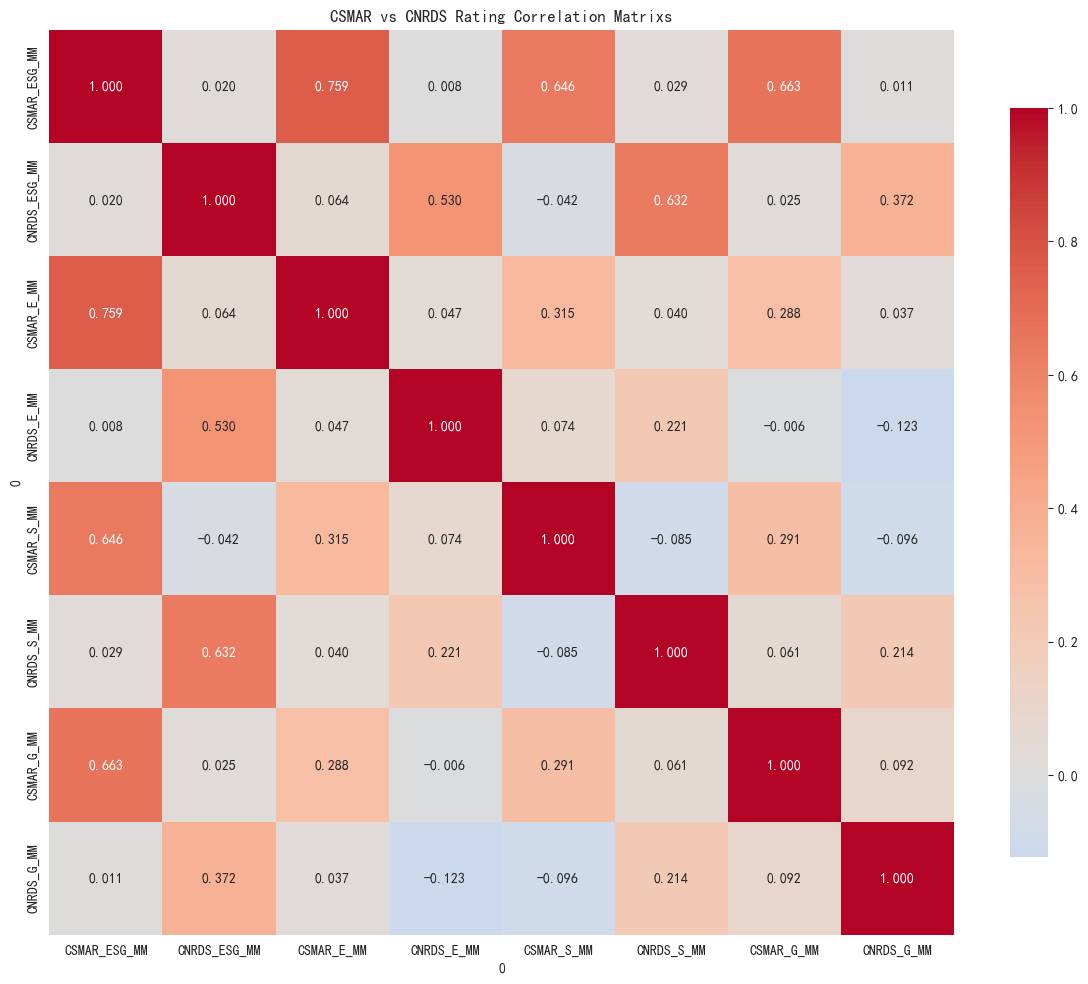

Cross-system correlation:
ESG: 0.0198
E: 0.0469
S: -0.0855
G: 0.0916


In [148]:
# Heatmap
correlation_cols = [
    'CSMAR_ESG_MM', 'CNRDS_ESG_MM', 'CSMAR_E_MM', 'CNRDS_E_MM',
    'CSMAR_S_MM', 'CNRDS_S_MM', 'CSMAR_G_MM', 'CNRDS_G_MM'
]

corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('CSMAR vs CNRDS Rating Correlation Matrixs')
plt.tight_layout()
plt.show()

# Focus on correlations across different systems.
print("Cross-system correlation:")
cross_correlations = []
for dim in ['ESG', 'E', 'S', 'G']:
    corr = df[f'CSMAR_{dim}_MM'].corr(df[f'CNRDS_{dim}_MM'])
    cross_correlations.append({'Dimension': dim, 'Cross_System_Correlation': corr})
    print(f"{dim}: {corr:.4f}")

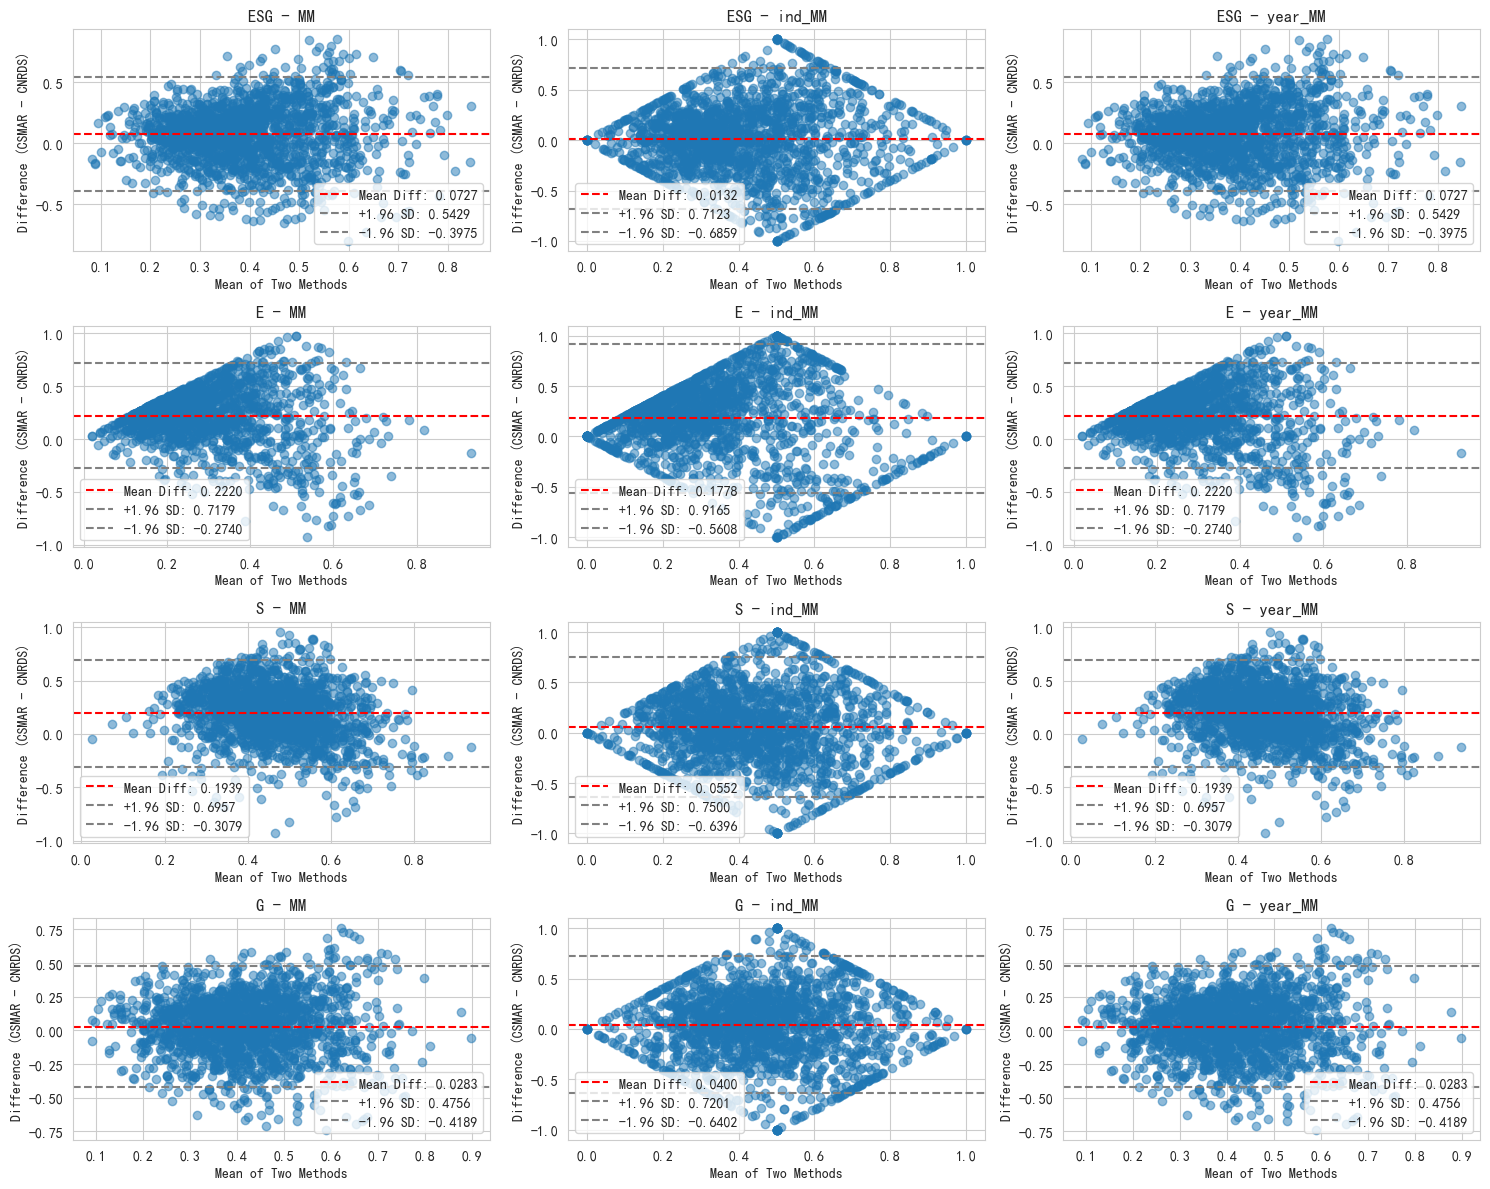

In [152]:
# Bland-Altman diagram
def bland_altman_plot(data1, data2, title, ax):
    """Plot Bland-Altman diagrams"""
    mean = (data1 + data2) / 2
    diff = data1 - data2
    mean_diff = diff.mean()
    std_diff = diff.std()
    
    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.4f}')
    ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', 
               label=f'+1.96 SD: {mean_diff + 1.96 * std_diff:.4f}')
    ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', 
               label=f'-1.96 SD: {mean_diff - 1.96 * std_diff:.4f}')
    ax.set_xlabel('Mean of Two Methods')
    ax.set_ylabel('Difference (CSMAR - CNRDS)')
    ax.set_title(title)
    ax.legend()

# Draw a Bland-Altman plot for each dimension.
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

plot_index = 0
for dim in dimensions:
    csmar_cols = [col for col in df.columns if f'CSMAR_{dim}_' in col and '_MM' in col]
    cnrds_cols = [col for col in df.columns if f'CNRDS_{dim}_' in col and '_MM' in col]
    
    for csmar_col, cnrds_col in zip(csmar_cols, cnrds_cols):
        # Extracting data
        data = df[[csmar_col, cnrds_col]].dropna()
        if len(data) < 10:
            continue
        
        bland_altman_plot(data[csmar_col], data[cnrds_col], 
                         f'{dim} - {csmar_col.replace(f"CSMAR_{dim}_", "")}', 
                         axes[plot_index])
        plot_index += 1

for i in range(plot_index, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

#### Correlation Result

In [166]:
# Convert continuous ratings to grades
def calculate_agreement_metrics(df, dimension, n_quantiles=5):
    """Calculate the consistency index between two rating systems."""
    
    # Create quantile groups
    csmar_quantile = pd.qcut(df[f'CSMAR_{dimension}_MM'], n_quantiles, labels=False, duplicates='drop')
    cnrds_quantile = pd.qcut(df[f'CNRDS_{dimension}_MM'], n_quantiles, labels=False, duplicates='drop')
    
    # Calculate consistency metrics
    accuracy = (csmar_quantile == cnrds_quantile).mean()
    kappa = cohen_kappa_score(csmar_quantile, cnrds_quantile)
    
    # Calculate rank correlation
    rank_correlation = df[f'CSMAR_{dimension}_MM'].corr(df[f'CNRDS_{dimension}_MM'], method='spearman')
    
    return {
        'Dimension': dimension,
        'Exact_Agreement': accuracy,
        'Cohens_Kappa': kappa,
        'Rank_Correlation': rank_correlation,
        'N_Observations': len(df)
    }

# Perform consistency analysis across all dimensions.
agreement_results = []
for dim in ['ESG', 'E', 'S', 'G']:
    result = calculate_agreement_metrics(df, dim)
    agreement_results.append(result)

agreement_df = pd.DataFrame(agreement_results)
print("Correlation Result:")
print(agreement_df.round(4))

Correlation Result:
  Dimension  Exact_Agreement  Cohens_Kappa  Rank_Correlation  N_Observations
0       ESG           0.1985       -0.0018            0.0321            1783
1         E           0.2199        0.0248            0.1188            1783
2         S           0.1935       -0.0081           -0.0600            1783
3         G           0.2182        0.0227            0.1073            1783


* The exact contract rate is approximately 19-22%, only slightly better than a random prediction (20%).
* The Cohen's Kappa coefficient is close to zero, even negative, indicating that consistency is no better than randomness.
* Rank correlation is very weak, with only 0.032 in the ESG dimension, 0.119 in the E dimension, negative (-0.060) in the S dimension, and 0.107 in the G dimension.

The consistency analysis between CSMAR and CNRDS ESG rating systems reveals fundamental divergences in their assessment methodologies. Across all dimensions (ESG, E, S, G), the exact agreement rates hover around only 20%, which is essentially equivalent to random chance given the quintile categorization used. More concerning are the Cohen's Kappa coefficients, which range from -0.0081 to 0.0248, indicating that the inter-rater reliability between the two systems is statistically no better than random assignment. The rank correlation coefficients further confirm this pattern, with values near zero (0.0321 for ESG) and even slightly negative for the social dimension (-0.0600).

These results suggest that CSMAR and CNRDS not only employ different scoring scales but fundamentally disagree on companies' relative ESG performances. The near-zero consistency metrics imply that the two systems capture different aspects of corporate sustainability or weight evaluation criteria differently. This has significant implications for both academic research and investment practice, as findings based on one rating system may not generalize to the other. The low consistency underscores the need for caution when comparing studies using different rating providers and highlights the contextual nature of ESG assessments in emerging markets.

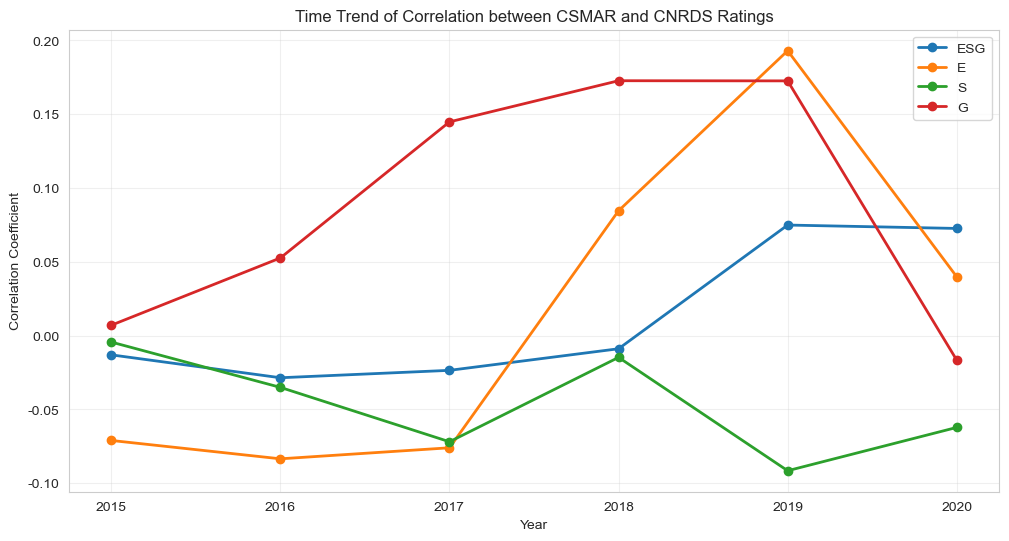

In [169]:
# Analyze correlation changes by year
yearly_correlations = []
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    year_corrs = {}
    for dim in ['ESG', 'E', 'S', 'G']:
        if len(year_data) > 10:  # Ensure sufficient data
            corr = year_data[f'CSMAR_{dim}_MM'].corr(year_data[f'CNRDS_{dim}_MM'])
            year_corrs[dim] = corr
    year_corrs['Year'] = year
    yearly_correlations.append(year_corrs)

yearly_corr_df = pd.DataFrame(yearly_correlations)

# Plot time trend
plt.figure(figsize=(12, 6))
for dim in ['ESG', 'E', 'S', 'G']:
    plt.plot(yearly_corr_df['Year'], yearly_corr_df[dim], marker='o', label=dim, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Correlation Coefficient')
plt.title('Time Trend of Correlation between CSMAR and CNRDS Ratings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Regression Analysis for ESG Dimension
                            OLS Regression Results                            
Dep. Variable:           CNRDS_ESG_MM   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7000
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.403
Time:                        11:42:55   Log-Likelihood:                 660.48
No. Observations:                1783   AIC:                            -1317.
Df Residuals:                    1781   BIC:                            -1306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const    

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Intercept': model.params[0],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope': model.params[1],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope_p_value': model.pvalues[1],


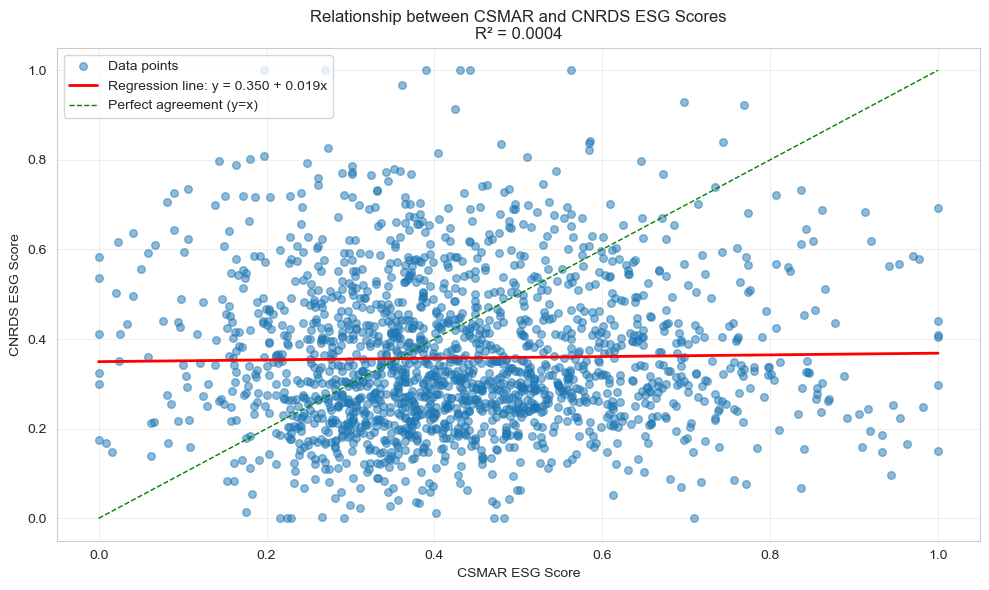


Regression Analysis for E Dimension
                            OLS Regression Results                            
Dep. Variable:             CNRDS_E_MM   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.919
Date:                Tue, 09 Dec 2025   Prob (F-statistic):             0.0479
Time:                        11:42:56   Log-Likelihood:                 409.79
No. Observations:                1783   AIC:                            -815.6
Df Residuals:                    1781   BIC:                            -804.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Intercept': model.params[0],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope': model.params[1],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope_p_value': model.pvalues[1],


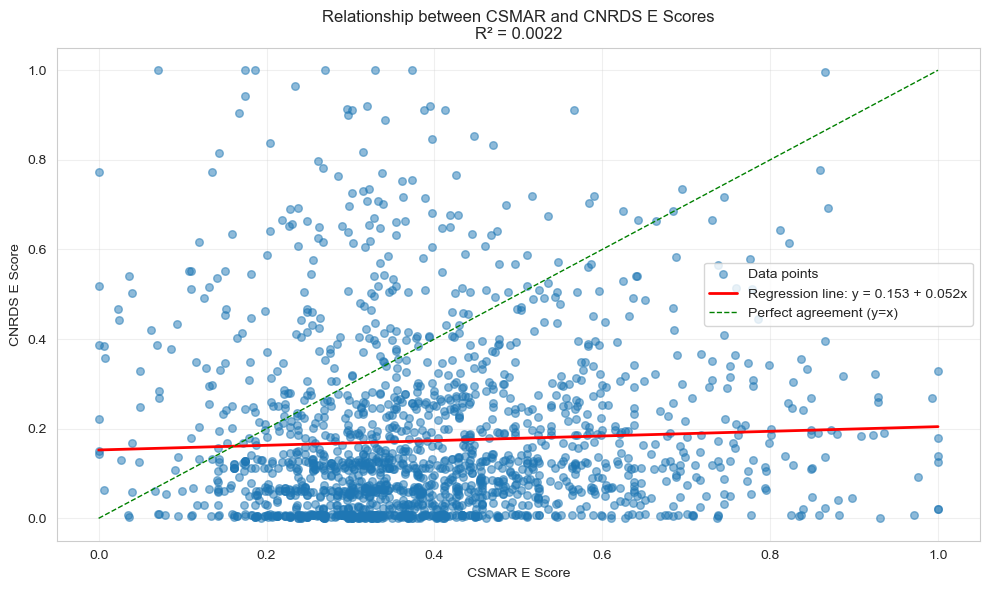


Regression Analysis for S Dimension
                            OLS Regression Results                            
Dep. Variable:             CNRDS_S_MM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     13.10
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           0.000303
Time:                        11:42:56   Log-Likelihood:                 421.94
No. Observations:                1783   AIC:                            -839.9
Df Residuals:                    1781   BIC:                            -828.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Intercept': model.params[0],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope': model.params[1],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope_p_value': model.pvalues[1],


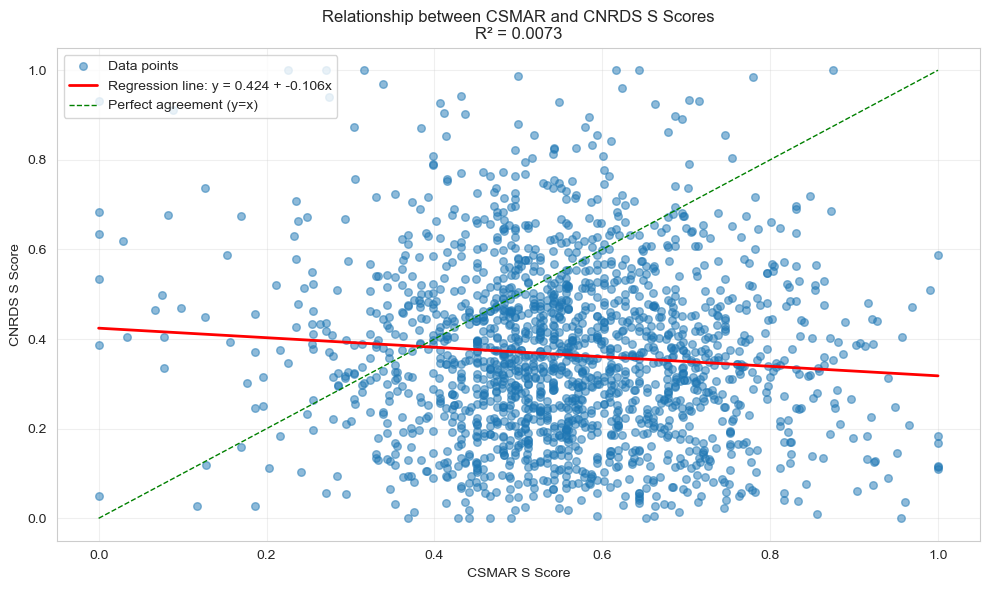


Regression Analysis for G Dimension
                            OLS Regression Results                            
Dep. Variable:             CNRDS_G_MM   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     15.08
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           0.000107
Time:                        11:42:57   Log-Likelihood:                 644.46
No. Observations:                1783   AIC:                            -1285.
Df Residuals:                    1781   BIC:                            -1274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Intercept': model.params[0],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope': model.params[1],
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\2119559688.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Slope_p_value': model.pvalues[1],


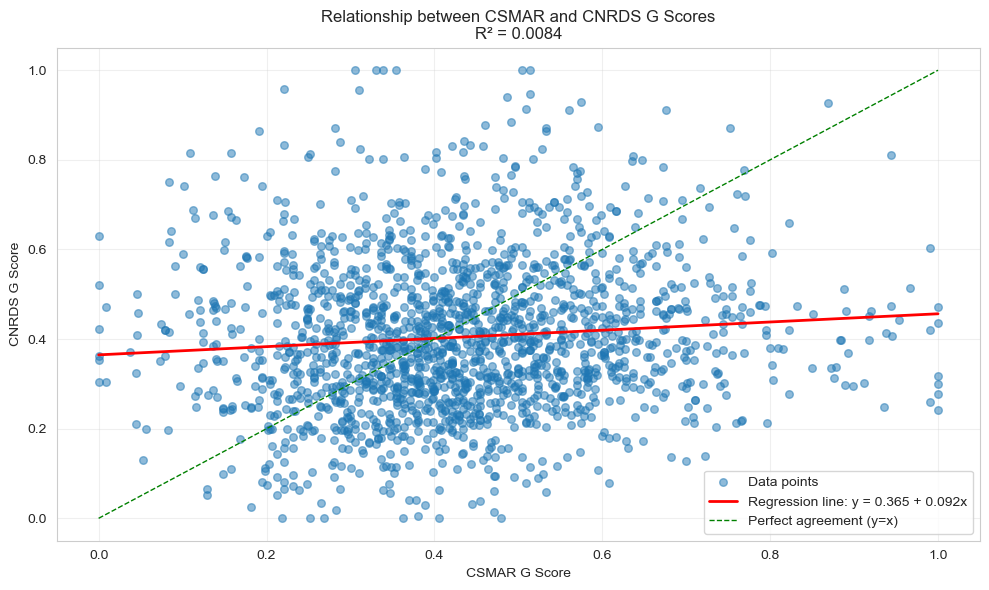


Regression Results Summary:
  Dimension  R_Squared   Slope  Intercept  Slope_p_value  N_Observations
0       ESG     0.0004  0.0189     0.3496         0.4029            1783
1         E     0.0022  0.0520     0.1526         0.0479            1783
2         S     0.0073 -0.1064     0.4243         0.0003            1783
3         G     0.0084  0.0917     0.3648         0.0001            1783


In [171]:
# Perform simple linear regression for each dimension
regression_results = []

for dim in ['ESG', 'E', 'S', 'G']:
    print(f"\n{'='*50}")
    print(f"Regression Analysis for {dim} Dimension")
    print(f"{'='*50}")
    
    # Preparing the data
    csmar_col = f'CSMAR_{dim}_MM'
    cnrds_col = f'CNRDS_{dim}_MM'
    
    # Remove missing values
    regression_data = df[[csmar_col, cnrds_col]].dropna()
    X = regression_data[csmar_col]
    y = regression_data[cnrds_col]
    
    # Add a constant term
    X = sm.add_constant(X)
    
    # Perform OLS regression
    model = sm.OLS(y, X).fit()
    
    # 提取关键结果
    results = {
        'Dimension': dim,
        'R_Squared': model.rsquared,
        'Adj_R_Squared': model.rsquared_adj,
        'Intercept': model.params[0],
        'Slope': model.params[1],
        'Slope_p_value': model.pvalues[1],
        'N_Observations': len(regression_data)
    }
    regression_results.append(results)
    
    # Print regression results
    print(model.summary())
    
    # Create a scatter plot and regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(regression_data[csmar_col], regression_data[cnrds_col], 
                alpha=0.5, s=30, label='Data points')
    
    # Add a regression line
    x_range = np.linspace(regression_data[csmar_col].min(), regression_data[csmar_col].max(), 100)
    y_pred = results['Intercept'] + results['Slope'] * x_range
    plt.plot(x_range, y_pred, color='red', linewidth=2, 
             label=f'Regression line: y = {results["Intercept"]:.3f} + {results["Slope"]:.3f}x')
    
    # Add a perfect consistency line (y=x)
    plt.plot(x_range, x_range, color='green', linestyle='--', 
             linewidth=1, label='Perfect agreement (y=x)')
    
    plt.xlabel(f'CSMAR {dim} Score')
    plt.ylabel(f'CNRDS {dim} Score')
    plt.title(f'Relationship between CSMAR and CNRDS {dim} Scores\nR² = {results["R_Squared"]:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create a summary table of regression results
regression_df = pd.DataFrame(regression_results)
print("\nRegression Results Summary:")
print("="*60)
display_cols = ['Dimension', 'R_Squared', 'Slope', 'Intercept', 'Slope_p_value', 'N_Observations']
print(regression_df[display_cols].round(4))

**Key Regression Results Between CSMAR and CNRDS ESG Ratings:**

• **Extremely Low Explanatory Power**: All R² values < 1% (ESG: 0.04%, E: 0.22%, S: 0.73%, G: 0.84%)

• **Divergent Relationship Patterns**:
  - ESG: No significant relationship (slope=0.019, p=0.403)
  - E: Marginally positive (slope=0.052, p=0.048)
  - S: Significantly negative (slope=-0.106, p=0.0003)
  - G: Significantly positive (slope=0.092, p=0.0001)

• **Systematic Scoring Bias**: All intercepts significantly different from zero, indicating fundamental scaling differences

Critical Findings:

The regression analysis reveals that CSMAR and CNRDS ESG rating systems capture fundamentally different aspects of corporate sustainability performance. The near-zero R² values across all dimensions indicate negligible predictive relationship between the two systems. Most alarmingly, the significant negative relationship in social (S) ratings suggests the systems hold opposing views on corporate social responsibility. These results demonstrate that the choice of ESG rating provider substantially influences research outcomes and investment decisions, as the systems cannot be used interchangeably.


### Violin Plot

In [175]:
# Set the graph style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Preparing the data - Creating long-format data for easier plotting
violin_data = []

for dim in ['ESG', 'E', 'S', 'G']:
    csmar_col = f'CSMAR_{dim}_MM'
    cnrds_col = f'CNRDS_{dim}_MM'
    
    # Extracting CSMAR data
    for score in df[csmar_col].dropna():
        violin_data.append({
            'Dimension': dim,
            'System': 'CSMAR',
            'Score': score
        })
    
    # Extracting CNRDS data
    for score in df[cnrds_col].dropna():
        violin_data.append({
            'Dimension': dim,
            'System': 'CNRDS',
            'Score': score
        })

violin_df = pd.DataFrame(violin_data)

Statistical Summary:
                    mean     std  median
Dimension System                        
E         CNRDS   0.1731  0.1926  0.1131
          CSMAR   0.3951  0.1734  0.3651
ESG       CNRDS   0.3578  0.1671  0.3250
          CSMAR   0.4304  0.1754  0.4088
G         CNRDS   0.4045  0.1693  0.3892
          CSMAR   0.4328  0.1693  0.4215
S         CNRDS   0.3649  0.1917  0.3508
          CSMAR   0.5588  0.1540  0.5508


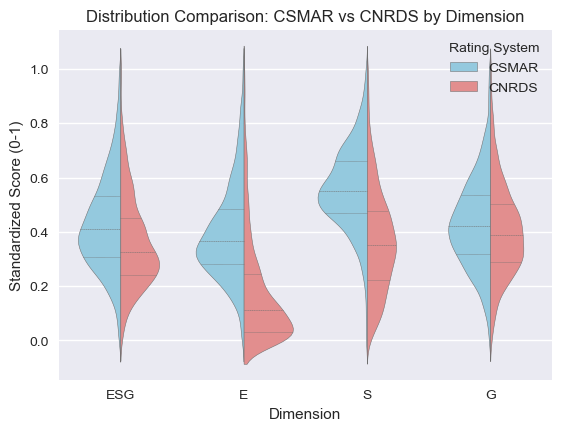

In [177]:
# Create violin plot
plt.figure(figsize=(14, 10))

# Main Chart - Showing the distribution of two systems grouped by dimension
plt.subplot(2, 2, 1)
sns.violinplot(data=violin_df, x='Dimension', y='Score', hue='System', 
               split=True, inner='quart', palette={'CSMAR': 'skyblue', 'CNRDS': 'lightcoral'})
plt.title('Distribution Comparison: CSMAR vs CNRDS by Dimension')
plt.ylabel('Standardized Score (0-1)')
plt.legend(title='Rating System')

# Add statistical summary
stats_summary = violin_df.groupby(['Dimension', 'System'])['Score'].agg(['mean', 'std', 'median']).round(4)
print("Statistical Summary:")
print(stats_summary)

C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1515468114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dim_data, x='System', y='Score',
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1515468114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dim_data, x='System', y='Score',
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1515468114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dim_data, x='System', y='Score',
C:\Users\wanyi\AppData\Local\Temp\ipykernel_1260\1515468114.py:9: FutureWarning: 

Passi

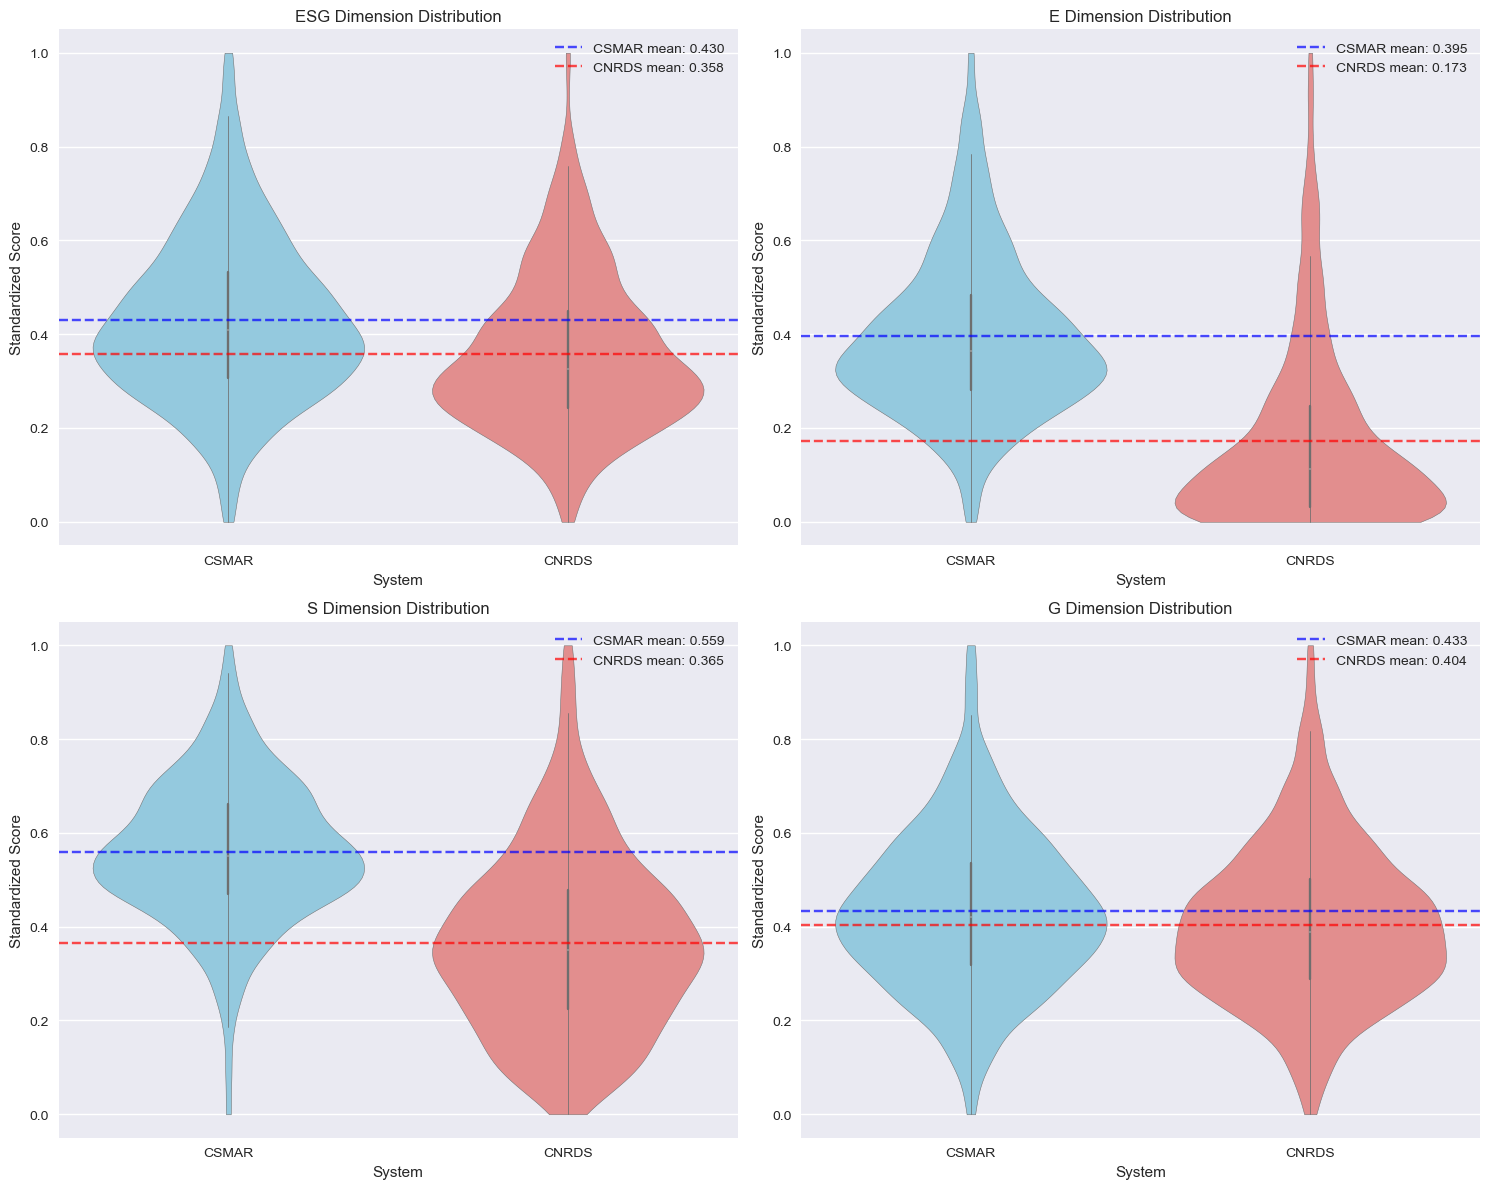

In [179]:
# Draw violin plots separately for each dimension.
dimensions = ['ESG', 'E', 'S', 'G']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, dim in enumerate(dimensions):
    dim_data = violin_df[violin_df['Dimension'] == dim]
    
    sns.violinplot(data=dim_data, x='System', y='Score', 
                   ax=axes[i], palette={'CSMAR': 'skyblue', 'CNRDS': 'lightcoral'},
                   inner='box', cut=0)
    
    # Add mean and standard deviation annotations
    csmar_mean = dim_data[dim_data['System'] == 'CSMAR']['Score'].mean()
    cnrds_mean = dim_data[dim_data['System'] == 'CNRDS']['Score'].mean()
    
    axes[i].axhline(y=csmar_mean, color='blue', linestyle='--', alpha=0.7, label=f'CSMAR mean: {csmar_mean:.3f}')
    axes[i].axhline(y=cnrds_mean, color='red', linestyle='--', alpha=0.7, label=f'CNRDS mean: {cnrds_mean:.3f}')
    
    axes[i].set_title(f'{dim} Dimension Distribution')
    axes[i].set_ylabel('Standardized Score')
    axes[i].legend()

plt.tight_layout()
plt.show()

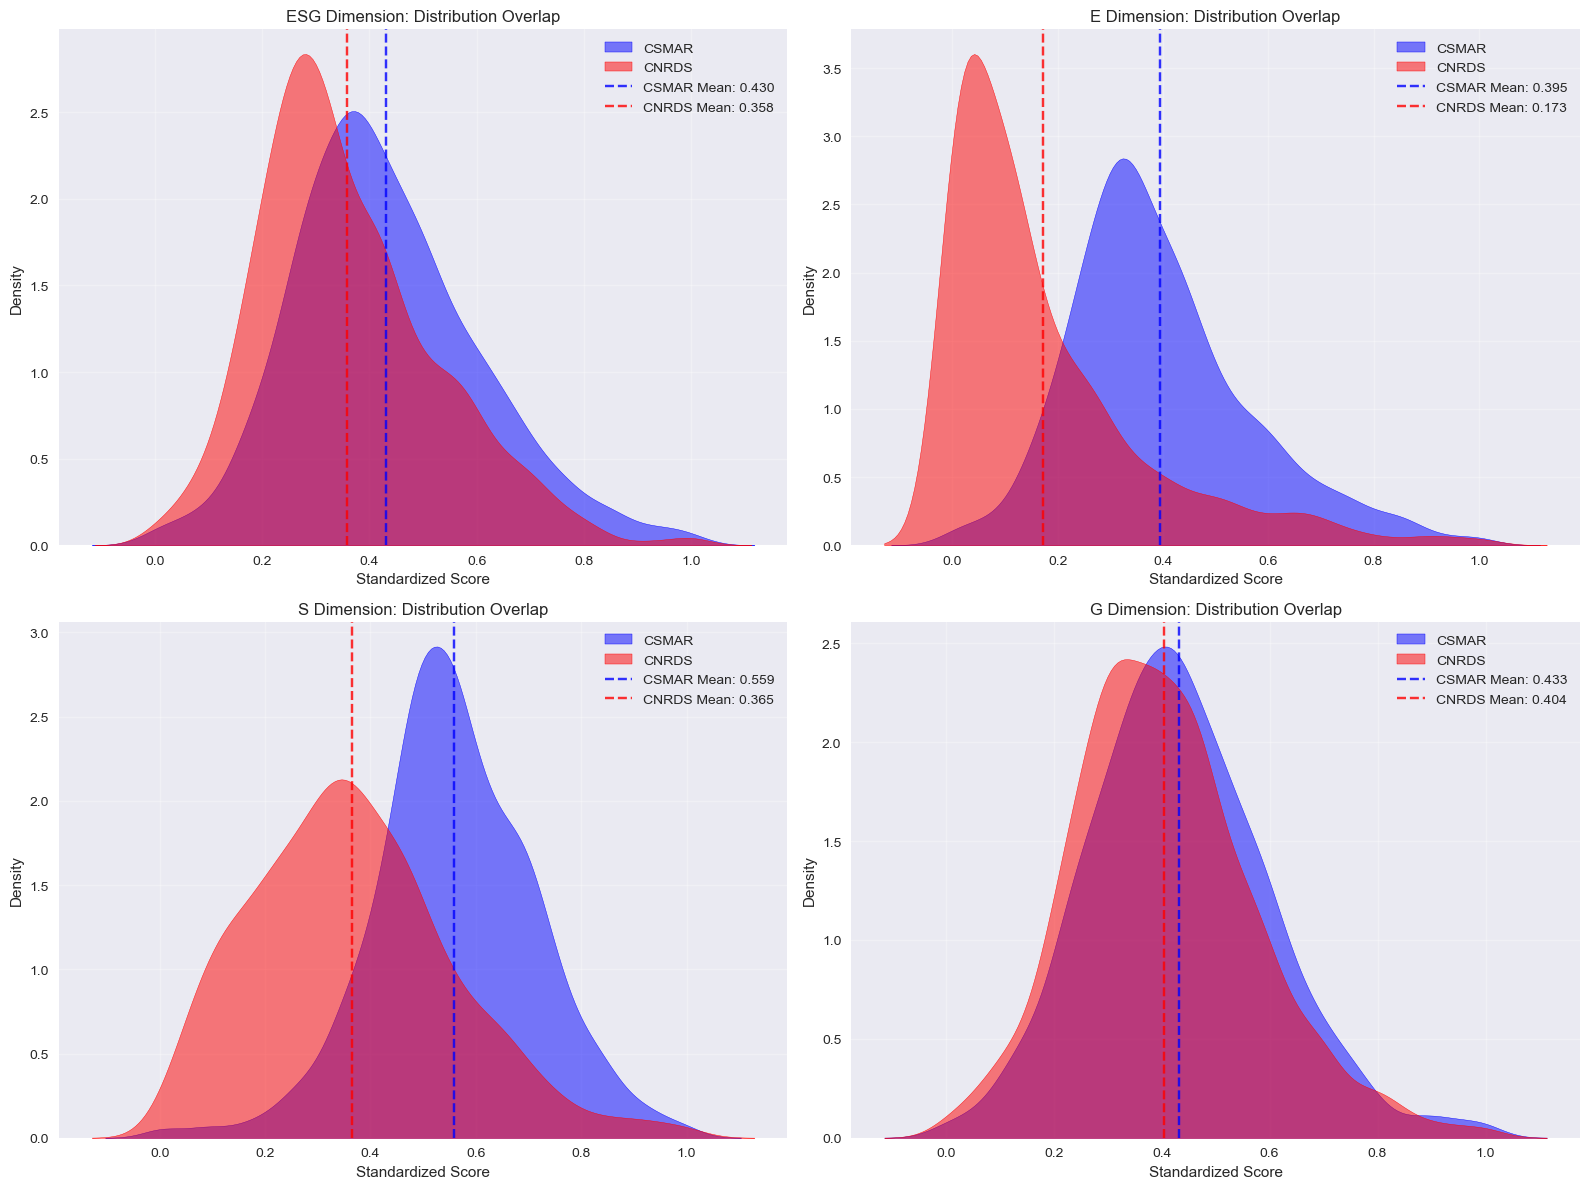

In [181]:
# Create a combined distribution plot to show the overlap
plt.figure(figsize=(16, 12))

for i, dim in enumerate(dimensions, 1):
    plt.subplot(2, 2, i)
    
    # Extracting data from two systems
    csmar_scores = df[f'CSMAR_{dim}_MM'].dropna()
    cnrds_scores = df[f'CNRDS_{dim}_MM'].dropna()
    
    # Plotting a density plot
    sns.kdeplot(csmar_scores, label='CSMAR', fill=True, alpha=0.5, color='blue')
    sns.kdeplot(cnrds_scores, label='CNRDS', fill=True, alpha=0.5, color='red')
    
    # Add mean and median lines
    plt.axvline(csmar_scores.mean(), color='blue', linestyle='--', alpha=0.8, label=f'CSMAR Mean: {csmar_scores.mean():.3f}')
    plt.axvline(cnrds_scores.mean(), color='red', linestyle='--', alpha=0.8, label=f'CNRDS Mean: {cnrds_scores.mean():.3f}')
    
    plt.xlabel('Standardized Score')
    plt.ylabel('Density')
    plt.title(f'{dim} Dimension: Distribution Overlap')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

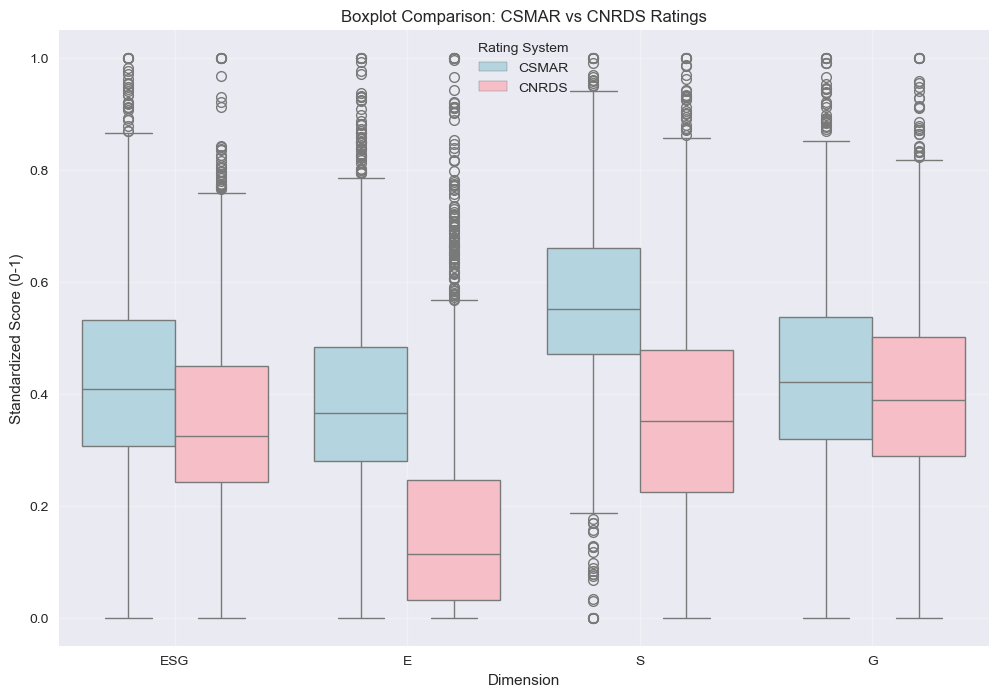

In [183]:
# Supplementary box plot comparison
plt.figure(figsize=(12, 8))
sns.boxplot(data=violin_df, x='Dimension', y='Score', hue='System', 
            palette={'CSMAR': 'lightblue', 'CNRDS': 'lightpink'})
plt.title('Boxplot Comparison: CSMAR vs CNRDS Ratings')
plt.ylabel('Standardized Score (0-1)')
plt.legend(title='Rating System')
plt.grid(True, alpha=0.3)
plt.show()

### Industry Level Analysis

Which industries are significantly different?   
alpha = 5%

In [191]:
# Set up Chinese font (if needed)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("Step 1: Identifying Industries with Significant Rating Differences")
print("=" * 70)

# Assuming your industry variable is 'Industry', please adjust according to actual situation
industry_col = 'CSMAR_Industry_1'  # Please replace with actual industry column name

# Check industry distribution
industry_counts = df[industry_col].value_counts()
print("Industry Distribution:")
print(industry_counts.head(10))  # Display top 10 industries

# Only keep industries with sufficient samples (e.g., at least 30 observations)
min_obs = 30
valid_industries = industry_counts[industry_counts >= min_obs].index
print(f"\nNumber of industries with sufficient samples: {len(valid_industries)}")

# Store industry difference test results
industry_results = []

for industry in valid_industries:
    industry_data = df[df[industry_col] == industry]
    
    industry_result = {'Industry': industry, 'N': len(industry_data)}
    
    for dim in ['ESG', 'E', 'S', 'G']:
        csmar_col = f'CSMAR_{dim}_MM'
        cnrds_col = f'CNRDS_{dim}_MM'
        
        # Extract data
        csmar_scores = industry_data[csmar_col].dropna()
        cnrds_scores = industry_data[cnrds_col].dropna()
        
        # Find common index
        common_idx = csmar_scores.index.intersection(cnrds_scores.index)
        if len(common_idx) < 10:  # Skip if too few samples
            continue
            
        csmar_common = csmar_scores.loc[common_idx]
        cnrds_common = cnrds_scores.loc[common_idx]
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(csmar_common, cnrds_common)
        mean_diff = csmar_common.mean() - cnrds_common.mean()
        
        industry_result[f'{dim}_Mean_Diff'] = mean_diff
        industry_result[f'{dim}_P_Value'] = p_value
        industry_result[f'{dim}_Significant'] = p_value < 0.05
    
    industry_results.append(industry_result)

# Convert to DataFrame
industry_df = pd.DataFrame(industry_results)

# Multiple testing correction
p_values = []
for dim in ['ESG', 'E', 'S', 'G']:
    p_values.extend(industry_df[f'{dim}_P_Value'].dropna().tolist())

# Apply FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Assign corrected p-values back to DataFrame
corrected_idx = 0
for dim in ['ESG', 'E', 'S', 'G']:
    for i in industry_df.index:
        if not pd.isna(industry_df.loc[i, f'{dim}_P_Value']):
            industry_df.loc[i, f'{dim}_P_Value_Corrected'] = pvals_corrected[corrected_idx]
            industry_df.loc[i, f'{dim}_Significant_Corrected'] = pvals_corrected[corrected_idx] < 0.05
            corrected_idx += 1

print("\nIndustry Difference Test Results (Top 10 Industries):")
display_cols = ['Industry', 'N'] + [f'{dim}_Mean_Diff' for dim in ['ESG', 'E', 'S', 'G']]
print(industry_df[display_cols].head(10).round(4))

# Identify industries with significant differences
significant_industries = set()
for dim in ['ESG', 'E', 'S', 'G']:
    sig_industries = industry_df[industry_df[f'{dim}_Significant_Corrected'] == True]['Industry'].tolist()
    significant_industries.update(sig_industries)
    print(f"\n{dim} Dimension - Industries with Significant Differences ({len(sig_industries)}):")
    for industry in sig_industries:
        mean_diff = industry_df[industry_df['Industry'] == industry][f'{dim}_Mean_Diff'].values[0]
        print(f"  {industry}: Difference = {mean_diff:.4f}")

print(f"\nTotal number of industries with significant differences: {len(significant_industries)}")

Step 1: Identifying Industries with Significant Rating Differences
Industry Distribution:
CSMAR_Industry_1
Manufacturing                                   593
Finance Industry                                325
Raw Materials Manufacturing                     166
Other Services                                  123
Software and Information Technology Services    118
Transportation, Storage and Postal Services      97
Real Estate                                      92
Mining Industry                                  85
Construction                                     74
Water Production and Supply                      65
Name: count, dtype: int64

Number of industries with sufficient samples: 10

Industry Difference Test Results (Top 10 Industries):
                                       Industry    N  ESG_Mean_Diff  \
0                                 Manufacturing  593         0.0549   
1                              Finance Industry  325         0.1749   
2                   Raw Mater

In [193]:
print("\nStep 2: In-depth Analysis of Industries with Significant Differences")
print("=" * 70)

# Detailed analysis for each industry with significant differences
for industry in significant_industries:
    print(f"\n{'='*50}")
    print(f"Industry Deep Dive: {industry}")
    print(f"{'='*50}")
    
    industry_data = df[df[industry_col] == industry]
    
    # Basic statistics
    print(f"Sample Size: {len(industry_data)}")
    
    # Dimension-wise difference analysis
    dimension_analysis = []
    for dim in ['ESG', 'E', 'S', 'G']:
        csmar_col = f'CSMAR_{dim}_MM'
        cnrds_col = f'CNRDS_{dim}_MM'
        
        csmar_scores = industry_data[csmar_col].dropna()
        cnrds_scores = industry_data[cnrds_col].dropna()
        
        common_idx = csmar_scores.index.intersection(cnrds_scores.index)
        csmar_common = csmar_scores.loc[common_idx]
        cnrds_common = cnrds_scores.loc[common_idx]
        
        if len(common_idx) < 5:
            continue
            
        mean_diff = csmar_common.mean() - cnrds_common.mean()
        relative_bias = mean_diff / ((csmar_common.mean() + cnrds_common.mean()) / 2) * 100
        
        # Calculate agreement metric
        agreement_5bin = (pd.cut(csmar_common, 5, labels=False) == pd.cut(cnrds_common, 5, labels=False)).mean()
        
        dimension_analysis.append({
            'Dimension': dim,
            'CSMAR_Mean': csmar_common.mean(),
            'CNRDS_Mean': cnrds_common.mean(),
            'Mean_Difference': mean_diff,
            'Relative_Bias_Percent': relative_bias,
            'Agreement_5bin': agreement_5bin,
            'Significant': industry_df[
                (industry_df['Industry'] == industry) & 
                (~industry_df[f'{dim}_Significant_Corrected'].isna())
            ][f'{dim}_Significant_Corrected'].iloc[0] if not industry_df[
                (industry_df['Industry'] == industry) & 
                (~industry_df[f'{dim}_Significant_Corrected'].isna())
            ].empty else False
        })
    
    analysis_df = pd.DataFrame(dimension_analysis)
    
    # Print analysis results
    print("\nDimension Comparison:")
    for _, row in analysis_df.iterrows():
        sig_flag = "***" if row['Significant'] else ""
        bias_direction = "CSMAR Higher" if row['Mean_Difference'] > 0 else "CNRDS Higher"
        print(f"  {row['Dimension']}: Difference={row['Mean_Difference']:.4f} ({bias_direction}), "
              f"Relative Bias={row['Relative_Bias_Percent']:.1f}%, Agreement={row['Agreement_5bin']:.3f}{sig_flag}")
    
    # Identify main difference patterns
    significant_dims = analysis_df[analysis_df['Significant']]
    if len(significant_dims) > 0:
        max_diff_dim = significant_dims.loc[significant_dims['Mean_Difference'].abs().idxmax()]
        print(f"\nLargest Difference Dimension: {max_diff_dim['Dimension']} "
              f"(Difference={max_diff_dim['Mean_Difference']:.4f}, Relative Bias={max_diff_dim['Relative_Bias_Percent']:.1f}%)")


Step 2: In-depth Analysis of Industries with Significant Differences

Industry Deep Dive: Construction
Sample Size: 74

Dimension Comparison:
  ESG: Difference=-0.0547 (CNRDS Higher), Relative Bias=-12.6%, Agreement=0.162
  E: Difference=0.2125 (CSMAR Higher), Relative Bias=66.3%, Agreement=0.203***
  S: Difference=-0.0640 (CNRDS Higher), Relative Bias=-12.3%, Agreement=0.216
  G: Difference=-0.0770 (CNRDS Higher), Relative Bias=-17.1%, Agreement=0.297***

Largest Difference Dimension: E (Difference=0.2125, Relative Bias=66.3%)

Industry Deep Dive: Other Services
Sample Size: 123

Dimension Comparison:
  ESG: Difference=0.0433 (CSMAR Higher), Relative Bias=12.7%, Agreement=0.260***
  E: Difference=0.2831 (CSMAR Higher), Relative Bias=137.1%, Agreement=0.114***
  S: Difference=0.1063 (CSMAR Higher), Relative Bias=25.0%, Agreement=0.236***
  G: Difference=-0.0834 (CNRDS Higher), Relative Bias=-18.6%, Agreement=0.260***

Largest Difference Dimension: E (Difference=0.2831, Relative Bias=1


Industry difference heatmap...


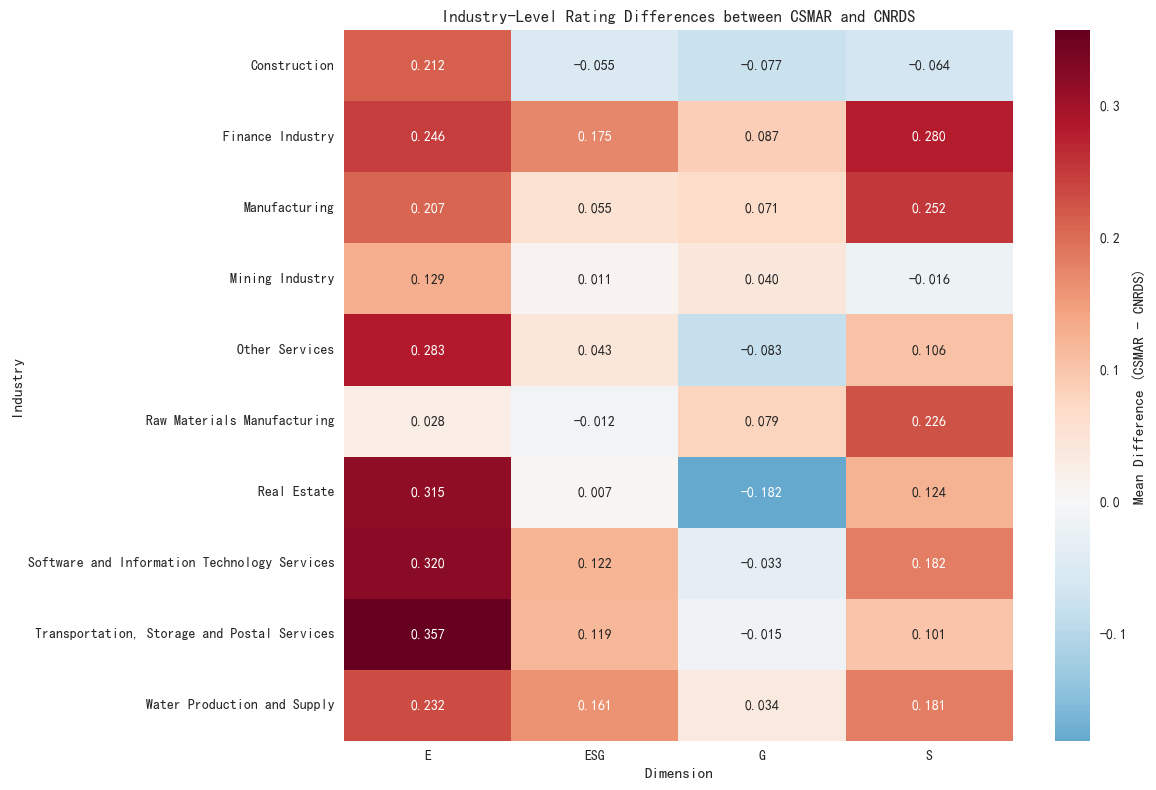


Industry Level Difference Visualization:
Industry
Finance Industry                                0.1969
Software and Information Technology Services    0.1643
Real Estate                                     0.1570
Water Production and Supply                     0.1518
Transportation, Storage and Postal Services     0.1480
Manufacturing                                   0.1461
Other Services                                  0.1290
Construction                                    0.1020
Raw Materials Manufacturing                     0.0863
Mining Industry                                 0.0488
dtype: float64


In [195]:
# Create an industry difference heatmap.
print("\nIndustry difference heatmap...")

# Preparing heatmap data
heatmap_data = []
for industry in significant_industries:
    for dim in ['ESG', 'E', 'S', 'G']:
        industry_row = industry_df[industry_df['Industry'] == industry]
        if len(industry_row) > 0 and not industry_row[f'{dim}_Mean_Diff'].isna().iloc[0]:
            mean_diff = industry_row[f'{dim}_Mean_Diff'].iloc[0]
            significant = industry_row[f'{dim}_Significant_Corrected'].iloc[0] if not industry_row[f'{dim}_Significant_Corrected'].isna().iloc[0] else False
            
            heatmap_data.append({
                'Industry': industry,
                'Dimension': dim,
                'Mean_Difference': mean_diff,
                'Significant': significant
            })

heatmap_df = pd.DataFrame(heatmap_data)

if len(heatmap_df) > 0:
    # Preparing heatmap data
    pivot_table = heatmap_df.pivot(index='Industry', columns='Dimension', values='Mean_Difference')
    
    plt.figure(figsize=(12, 8))
    
    # Create significance markers
    significance_table = heatmap_df.pivot(index='Industry', columns='Dimension', values='Significant')
    
    # Draw a heatmap
    mask = pivot_table.isnull()
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', cbar_kws={'label': 'Mean Difference (CSMAR - CNRDS)'},
                mask=mask)
    
    plt.title('Industry-Level Rating Differences between CSMAR and CNRDS')
    plt.tight_layout()
    plt.show()
    
    # Create industry-specific rankings
    print("\nIndustry Level Difference Visualization:")
    industry_avg_diff = pivot_table.abs().mean(axis=1).sort_values(ascending=False)
    print(industry_avg_diff.head(10).round(4))

### Difference Without Standardization

In [205]:
# Ensure that the numerical columns are of a numerical data type.
for col in ["ESG_CNRDS", "E_CNRDS", "S_CNRDS", "G_CNRDS",
            "ESG_CSMAR", "E_CSMAR", "S_CSMAR", "G_CSMAR"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Grouping: By year and primary industry (CSRC_Industry)
grouped = (
    df.groupby(["Year", "CSMAR_Industry"], as_index=False)
      .agg({
          "ESG_CNRDS": "mean",
          "E_CNRDS": "mean",
          "S_CNRDS": "mean",
          "G_CNRDS": "mean",
          "ESG_CSMAR": "mean",
          "E_CSMAR": "mean",
          "S_CSMAR": "mean",
          "G_CSMAR": "mean"
      })
)

# New column names 
grouped = grouped.rename(columns={
    "ESG_CNRDS": "CNRDS_ESG",
    "E_CNRDS": "CNRDS_E",
    "S_CNRDS": "CNRDS_S",
    "G_CNRDS": "CNRDS_G",
    "ESG_CSMAR": "CSMAR_ESG",
    "E_CSMAR": "CSMAR_E",
    "S_CSMAR": "CSMAR_S",
    "G_CSMAR": "CSMAR_G"
})

# Sort (by Year and Industry Name)
grouped = grouped.sort_values(["Year", "CSMAR_Industry"]).reset_index(drop=True)

# Show
print(grouped.head(10))


0  Year                                     CSMAR_Industry  CNRDS_ESG  \
0  2015                                        Agriculture  21.596350   
1  2015                                      Air Transport  18.135450   
2  2015                                  Business Services  27.432525   
3  2015                            Capital Market Services  22.368352   
4  2015                     Civil Engineering Construction  33.744625   
5  2015                            Coal Mining and Washing  32.756750   
6  2015                                      Comprehensive  34.330967   
7  2015                                       Construction  27.743050   
8  2015                                   Culture and Arts  10.848300   
9  2015  Ecological Protection and Environmental Govern...  29.753100   

0    CNRDS_E    CNRDS_S    CNRDS_G  CSMAR_ESG    CSMAR_E    CSMAR_S    CSMAR_G  
0   3.381900  25.545900  35.295900  48.062500  17.125000  17.062500  13.875000  
1   3.523350  28.385450  24.700333

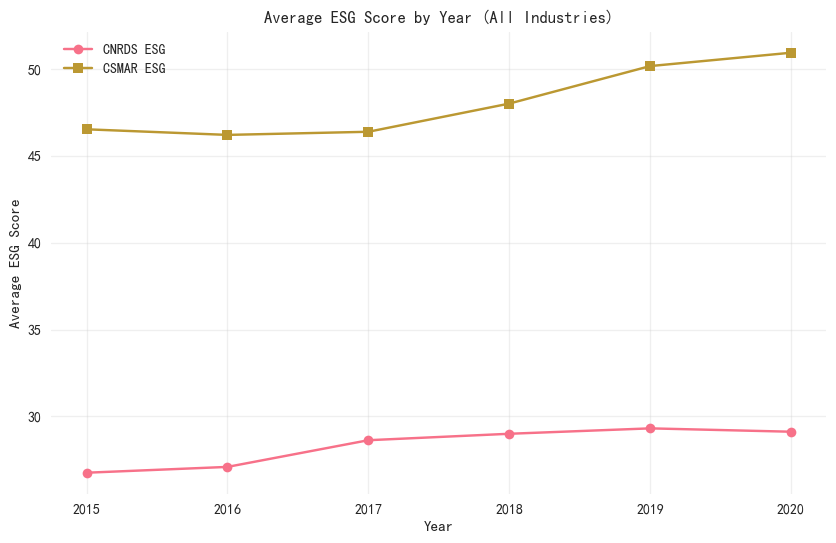

In [207]:
# Basic Preparation 
# Calculate the overall average of the two systems by year.
overall_trend = grouped.groupby("Year")[["CNRDS_ESG", "CSMAR_ESG"]].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(overall_trend["Year"], overall_trend["CNRDS_ESG"], marker='o', label="CNRDS ESG")
plt.plot(overall_trend["Year"], overall_trend["CSMAR_ESG"], marker='s', label="CSMAR ESG")
plt.title("Average ESG Score by Year (All Industries)")
plt.xlabel("Year")
plt.ylabel("Average ESG Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


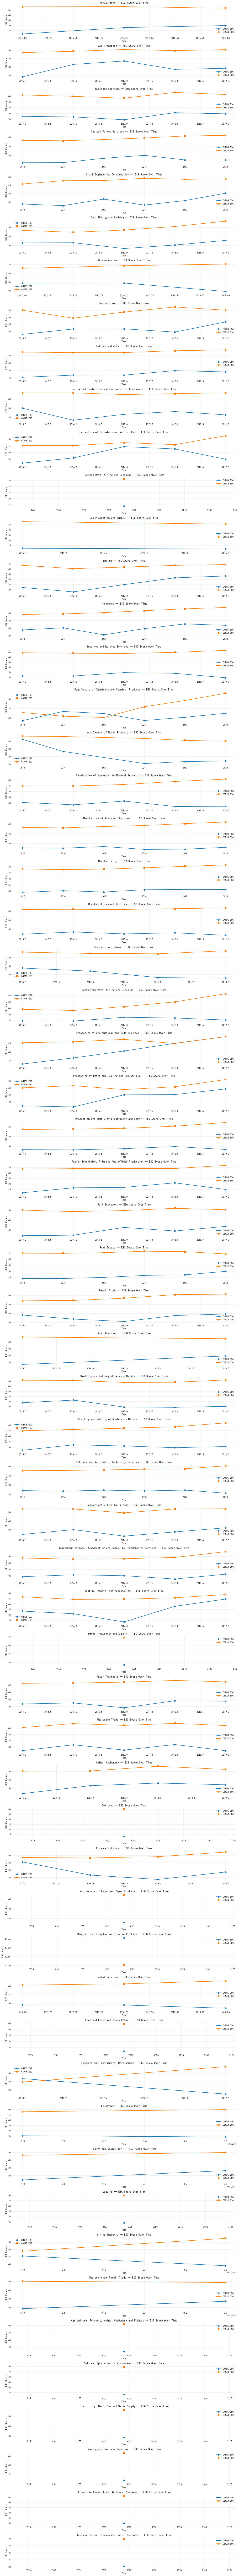

In [213]:
industries = grouped["CSMAR_Industry"].unique()
n = len(industries)

plt.figure(figsize=(14, n * 2.5))
for i, industry in enumerate(industries, 1):
    subset = grouped[grouped["CSMAR_Industry"] == industry]
    plt.subplot(n, 1, i)
    plt.plot(subset["Year"], subset["CNRDS_ESG"], marker='o', label="CNRDS ESG", color="tab:blue")
    plt.plot(subset["Year"], subset["CSMAR_ESG"], marker='s', label="CSMAR ESG", color="tab:orange")
    plt.title(f"{industry} — ESG Score Over Time")
    plt.xlabel("Year")
    plt.ylabel("ESG Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 5 industries (by CSMAR ESG mean):
Index(['Mining Industry', 'Manufacture of Chemicals and Chemical Products',
       'Processing of Agricultural and Sideline Food',
       'Manufacture of Rubber and Plastic Products',
       'Extraction of Petroleum and Natural Gas'],
      dtype='object', name='CSMAR_Industry')


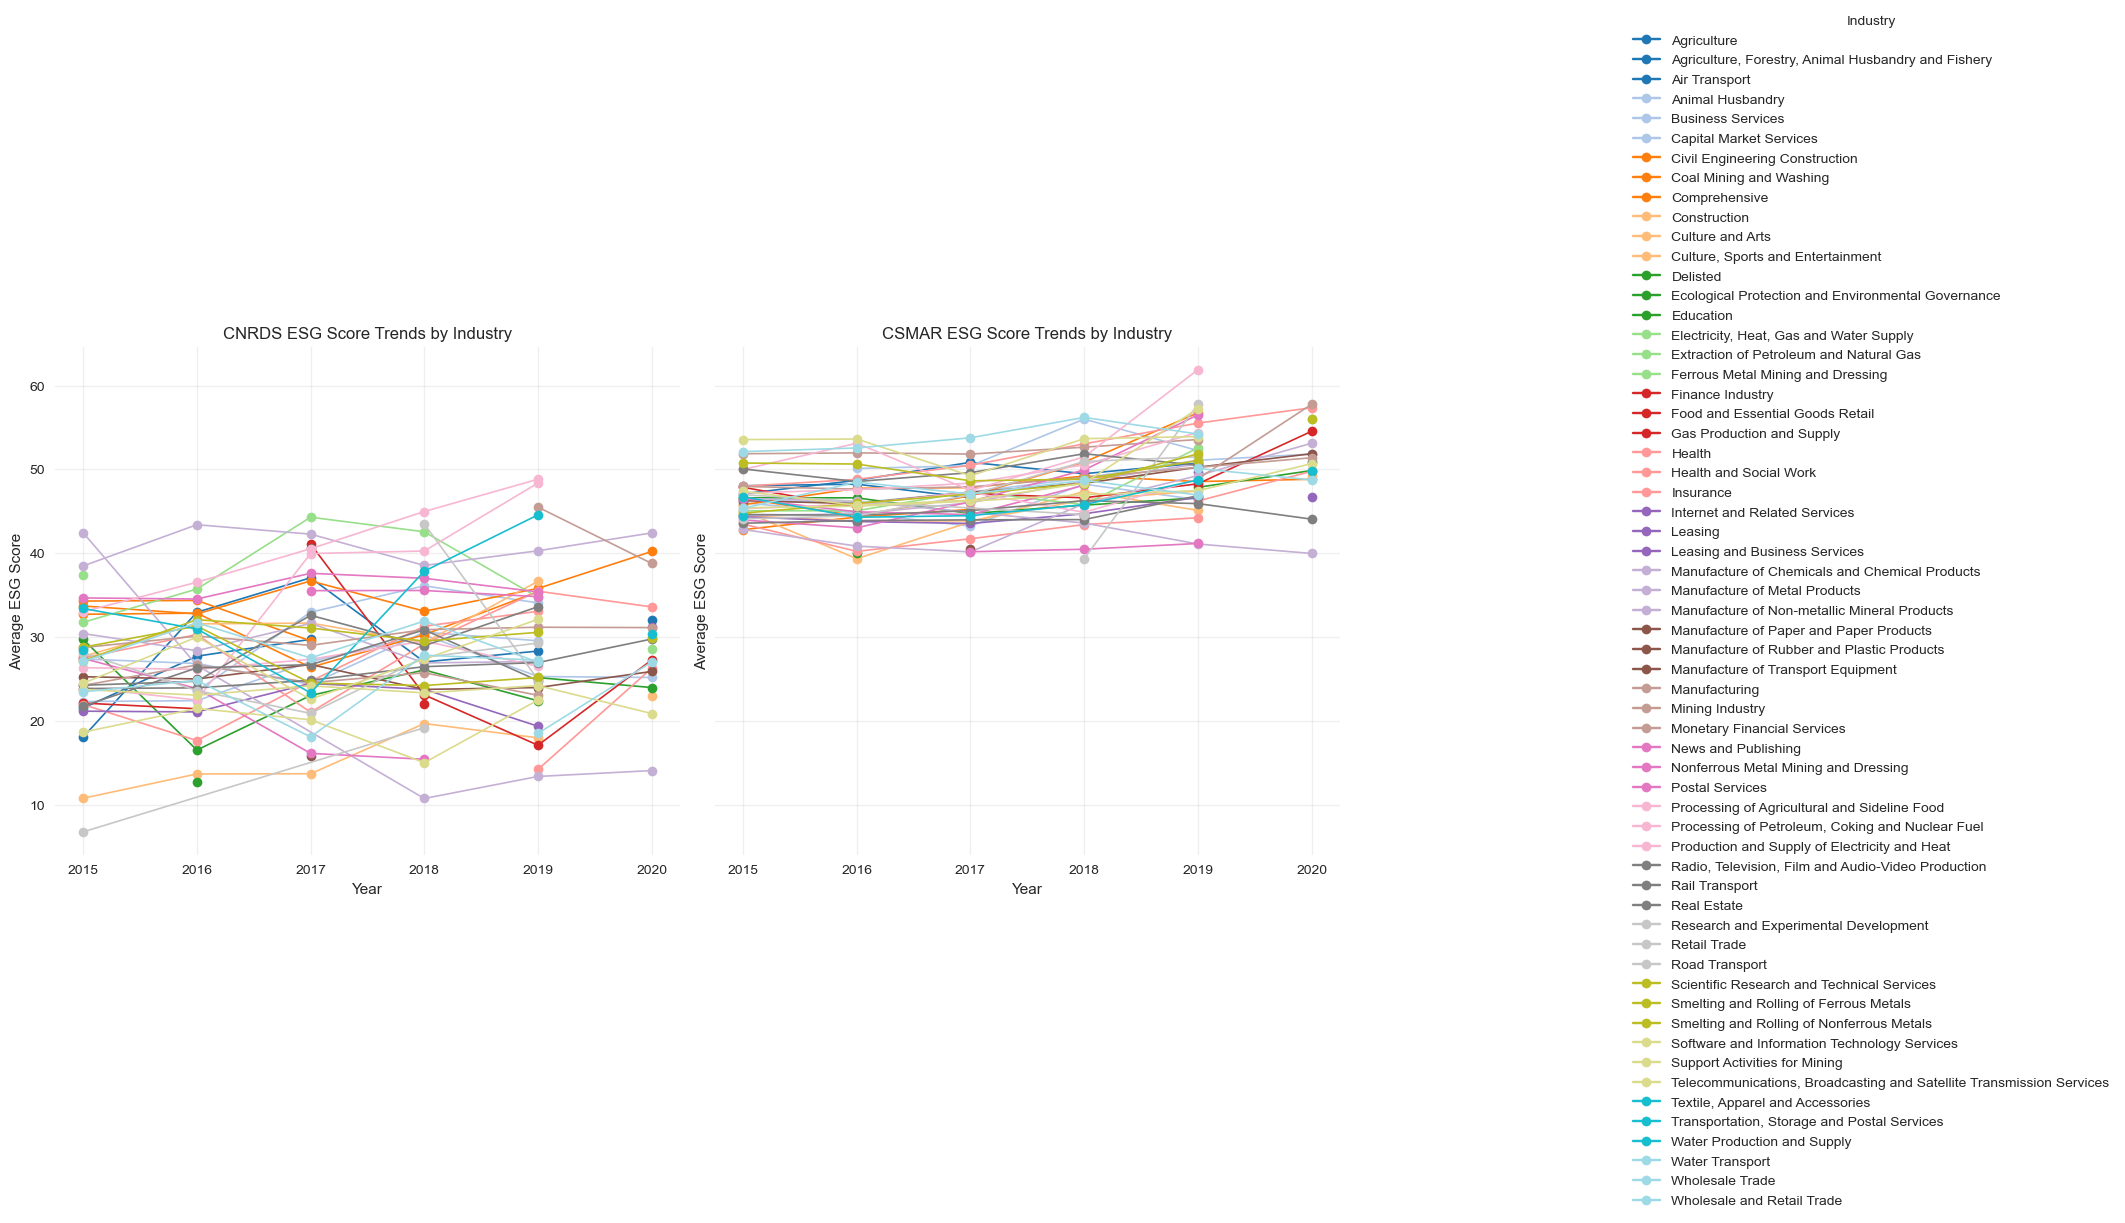

In [219]:
top5 = (
    grouped.groupby("CSMAR_Industry")["CNRDS_ESG"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)
print("Top 5 industries (by CSMAR ESG mean):")
print(top5)

industries = sorted(top5)


# grouped: columns ["Year","CSRC_Industry","CNRDS_ESG","CSMAR_ESG"]

# Unified industry color mapping (shared by both charts)
industries = sorted(grouped["CSMAR_Industry"].unique())
cmap = plt.get_cmap("tab20", len(industries))
color_map = {ind: cmap(i) for i, ind in enumerate(industries)}

# Draw two independent plots (sharing the y-axis), keeping only one overall legend on the right side, without obstructing the plots.
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ind in industries:
    sub = grouped[grouped["CSMAR_Industry"] == ind].sort_values("Year")
    color = color_map[ind]
    axes[0].plot(sub["Year"], sub["CNRDS_ESG"], marker="o", linewidth=1.2, color=color)
    axes[1].plot(sub["Year"], sub["CSMAR_ESG"], marker="o", linewidth=1.2, color=color)

# Left: CNRDS; Right: CSMAR
axes[0].set_title("CNRDS ESG Score Trends by Industry")
axes[1].set_title("CSMAR ESG Score Trends by Industry")
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Average ESG Score")
    ax.grid(alpha=0.3)

# 只生成一个行业颜色图例，放到右侧
legend_handles = [mlines.Line2D([], [], color=color_map[ind], marker="o", linestyle="-", label=ind)
                  for ind in industries]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           title="Industry", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右侧留空给图例
plt.show()
